In [3]:
from time import time
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
from nltk.corpus import stopwords
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import datetime

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Merge, Lambda
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [4]:
ls

dev_original_related_subject_body_merged.json
org_rel_body_2_categories.pkl
org_rel_body_3_categories.pkl
original_related_body_relevance_pairs.json
original_related_subject_body_relevance_pairs.json
original_related_subject_relevance_pairs.json
siamese_embeddings.pickle
siamese_post_process_dump.pickle
test.csv
train.csv
train_part1_original_related_body_pairs.json
train_part1_original_related_subject_body_merged.json
train_part2_original_related_body_pairs.json
train_part2_original_related_subject_body_merged.json


In [ ]:
# import json
# dev_file = open('dev_original_related_subject_body_merged.json')
# data_dev = json.load(dev_file)

# train_part1_file = open('train_part1_original_related_subject_body_merged.json')
# data_train_part1 = json.load(train_part1_file)


# train_part2_file = open('train_part2_original_related_subject_body_merged.json')
# data_train_part2 = json.load(train_part2_file)


In [ ]:
# import csv
# with open('train.csv', 'w', newline='') as csvfile:
#     writer = csv.writer(csvfile, delimiter=',',
#                             quotechar='|', quoting=csv.QUOTE_MINIMAL)
    
#     writer.writerow(['id', 'qid1', 'qid2', 'question1', 'question2', 'relevance'])
    
#     for idx, elem in enumerate(data_dev + data_train_part1):
#         writer.writerow([idx, idx*2+1, idx*2+2, elem['original_question'], elem['related_question'], elem['relevance']])
    
# with open('test.csv', 'w', newline='') as csvfile:
#     writer = csv.writer(csvfile, delimiter=',',
#                             quotechar='|', quoting=csv.QUOTE_MINIMAL)
    
#     writer.writerow(['id', 'qid1', 'qid2', 'question1', 'question2', 'relevance'])
    
#     for idx, elem in enumerate(data_train_part2):
#         writer.writerow([idx, idx*2+1, idx*2+2, elem['original_question'], elem['related_question'], elem['relevance']])
    
    

In [5]:
TRAIN_CSV = './train_set_distribution_diagram.csv'
TEST_CSV = './validation_set_distribution_diagram.csv'
EMBEDDING_FILE = '../GoogleNews-vectors-negative300.bin.gz'

train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)
stops = set(stopwords.words('english'))


In [10]:
test_df

id question1_id question2_id  \
0    1478         Q148     Q148_R27   
1     373          Q38      Q38_R25   
2     386         Q239     Q239_R31   
3      39           Q4       Q4_R28   
4     190          Q20       Q20_R7   
5     579         Q258     Q258_R85   
6    1883         Q189     Q189_R12   
7     467         Q247     Q247_R57   
8    1186         Q119     Q119_R63   
9    1750         Q176     Q176_R24   
10   1336         Q134     Q134_R40   
11    289          Q29      Q29_R75   
12    754          Q76      Q76_R37   
13   1209         Q121     Q121_R35   
14   1299         Q130     Q130_R36   
15    532         Q254      Q254_R9   
16    232         Q291     Q291_R13   
17    162          Q17      Q17_R17   
18   1444         Q145     Q145_R29   
19    184         Q219     Q219_R33   
20    341         Q302     Q302_R12   
21    408          Q41      Q41_R47   
22    867          Q87      Q87_R56   
23   1045         Q105     Q105_R11   
24   1802         Q181     Q181_R37   
25    570          Q58       Q58_R7   
26     73         Q208     Q208_R11   
27   1466         Q147     Q147_R28   
28    285         Q229      Q229_R9   
29     82         Q276     Q276_R11   
..    ...          ...          ...   
604  1083         Q109     Q109_R29   
605   145         Q215     Q215_R56   
606   669         Q267     Q267_R48   
607    39         Q271     Q271_R74   
608  1888         Q189     Q189_R22   
609  1550         Q156     Q156_R11   
610   451         Q313      Q313_R6   
611  1347         Q135     Q135_R36   
612   592          Q60      Q60_R21   
613   157         Q216     Q216_R75   
614  1968         Q197     Q197_R61   
615   395         Q240     Q240_R31   
616   863          Q87      Q87_R32   
617   111         Q279      Q279_R6   
618  1772         Q178     Q178_R31   
619   442          Q45       Q45_R3   
620  1068         Q107     Q107_R23   
621    73         Q275     Q275_R24   
622    47         Q272     Q272_R40   
623   187         Q219     Q219_R57   
624  1661         Q167     Q167_R15   
625    96         Q277     Q277_R21   
626  1261         Q127     Q127_R26   
627  1093         Q110     Q110_R20   
628   647          Q65      Q65_R55   
629  1654         Q166     Q166_R17   
630   590         Q260      Q260_R5   
631  1266         Q127     Q127_R59   
632   622          Q63       Q63_R8   
633   846          Q85      Q85_R58   

                                             question1  \
0    can anybody tell me when is the trade fair com...   
1    Can we bring our 40 days old baby with out a v...   
2    Liquor Permit. Can anyone tell me what is the ...   
3    how can my boyfriend get me and our baby son a...   
4    another question about sponsorship. Hypothetic...   
5    Passport while travelling?. Where do you keep ...   
6    What is the best time to migrate to Qatar for ...   
7    Is there any Art college here in qatar?. Is th...   
8    Is it possible to get family visa for my siste...   
9    Are the rents expected to go up?. Does anyone ...   
10   Is it True?. Hi Guy's; I am planning to buy a ...   
11   how can i travel from qatar to australia. help...   
12                    Books. Where can i donate books?   
13   Any Idea ? Any Guess?. Any Idea? Any Guess? 1....   
14   Can you wear shorts in public in Qatar?. My fa...   
15   resign?. hi good morning...Qlers.. i am an emp...   
16   Daycare near WestBay Area. Hi; I will arrive f...   
17   Where's the best Manicure ?. My buddy Pajju is...   
18   How to advertise to Qataris?. HI. I really nee...   
19   Platao... and those are. some pics of MY aquar...   
20   international driver licence. Hi; I am coming ...   
21   How many days does it take to have Family Visi...   
22   Can I come back to Qatar after finishing my co...   
23   can unmarried girls work in qatar?. hi.. I hav...   
24   Is police clearance required for all transfers...   
25   Sherborne Qatar. Has anyone else had problems ...   
26   How safe is it to

In [7]:
def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text

vocabulary = dict()
inverse_vocabulary = ['<unk>']

print("Started loading google vectors...")
# '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

print("Finished loading google vectors...")

questions_cols = ['question1', 'question2']

# Iterate over the questions only of both training and test datasets
# for dataset in [train_df, test_df]:
for dataset in [train_df, test_df]:
    for index, row in dataset.iterrows():
        


        # Iterate through the text of both questions of the row
        for question in questions_cols:
            
            print(question)
            
            q2n = []  # q2n -> question numbers representation
            for word in text_to_word_list(row[question]):
                
                print(word + "\n")

                # Check for unwanted words
                if word in stops and word not in word2vec.vocab:
                    continue

                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    q2n.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    q2n.append(vocabulary[word])

            # Replace questions as word to question as number representation
            dataset.set_value(index, question, q2n)
            
embedding_dim = 300
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
embeddings[0] = 0  # So that the padding will be ignored

# Build the embedding matrix
for word, index in vocabulary.items():
    if word in word2vec.vocab:
        embeddings[index] = word2vec.word_vec(word)

del word2vec

Started loading google vectors...
Finished loading google vectors...
question1
where

is

doha

clinic

can

anybody

tell

me

where

is

doha

clinic

question2
giving

birth

in

qatar

is

there

any

private

clinic

in

qatar

or

hospital

that

i

can

give

birth

which

cost

only

10;000

riyal

cause

my

doctor

said

if

i

give

birth

in

doha

clinic

it

will

cause

me

around

20;000

to

25;000

riyal

i

dont

want

in

hamad

hospital

so

pls

can

u

suggest

other

private

hospital

that

will

cost

me

less

thank

you

question1
eye

test

are

there

any

eye

test

center

in

city

center

accredited

by

trafic

department

question2
driving

licence

and

eyesight

i

am

about

to

apply

for

my

driving

licence

i

wear

glasses

50

of

the

time

and

contact

lenses

50

of

the

time

should

my

picture

show

me

wearing

glasses

or

contacts

question1
pet

shop

hi

!

would

someone

know

any

nearby

pet

shop

to

get

fishes

eg

gol

there;

do

please

pm

me

i

need

to

visit

this

village

but

dont

speak

malayalee

appreciate

any

assistance;

thank

you

question2
thai

food

where

the

best

place

to

get

really

good

thai

food;

my

favorite

meal

question1
can

i

drive

my

friends

car

my

father

and

mother

are

coming

to

qatar

for

4

weeks

holiday

if

my

father

has

an

international

driving

license

can

he

drive

my

car

legally

with

no

problems

with

the

police

if

there

is

an

accident

question2
drink

driving

has

anyone

been

caught

drink

driving

here

i

got

caught

last

week;

just

wondering

what

penalty

i

can

expect

hoping

for

just

a

fine

but

wondering

if

anyone

has

had

worse

punishment

also

can

you

leave

the

cuntry

spelt

on

purpose

by

the

way

!

whilst

still

awaiting

ur

trial

cheers

question1
do

i

have

to

cover

my

head

in

doha

i

dont

know

thts

the

reason

i

ask

if

somebody

can

tell

me

is

ever


everyone;

in

a

few

weeks

i

am

about

to

start

working

for

qatar

airways

as

a

cabin

crew

does

anyone

know

what

is

the

avarage

flying

time

a

month

for

a

cabin

crew

does

it

vary

for

those

who

just

started

working

than

for

those

who

work

for

qr

for

some

time

if

you

get

a

3

year

contract

is

it

possible

to

get

some

promotion

after

a

year

or

two

or

you

just

have

to

work

on

the

same

position

and

for

the

same

salary

for

those

3

years

thanks

in

advance

question1
at

night

what

is

the

clubbing

scene

in

doha

i

left

a

cool

lifestyle

in

mumbai

for

little

more

money

and

i

am

stuck

here

i

heard

about

liquor

licence;

qdc

n

all

i

will

be

getting

my

id

this

week

after

that

i

can

go

for

that

but

apart

from

that

can

anybody

tell

me

what

the

nightlife

available

here

how

much

i

need

to

spend;

where

are

the

places

etc

etc

question2
corniche

at

n


were

starting

to

find

a

english

school

for

my

son

he

is

4

years

old

advise

please

question1
can

i

get

a

car

old

or

new

for

rental

for

less

than

1000

riyal

if

any

body

know

about

any

car

less

than

1000

riyal

for

rental;please

answer

me

question2
xbox

360

i

am

looking

for

xbox

360

anyone

knows

where

i

can

find

it

in

doha

i

could

not

find

it

hyatt

plaza;

does

anyone

know

of

some

other

place

that

sells

it

and

how

much

it

costs

question1
can

we

bring

our

40

days

old

baby

with

out

a

visa

i

am

working

as

a

technician

in

a

private

company

and

my

wife

is

working

as

a

nurse

in

hammed

hospital

but

both

of

us

are

in

different

sponsorship

could

you

please

advice;

can

we

bring

our

baby

40

days

old

without

a

visa

and

what

are

the

documents

required

question2
medical

examination

info

hi

all

i

finished

my

medical

exam

here

in

doha

i

would

li


doha

and

back

looking

for

transportation

from

al

khor

to

doha

in

the

morning

and

from

doha

to

al

khor

in

the

afternoon

from

sunday

to

thursday

question2
any

one

who

likes

cycling

looking

for

somebody

to

ride

with

or

any

cycling

club

that

will

welcome

me

mail

me

at

onin

edward

yahoo

com

thanks

question1
what

if

eye

contact

leads

an

spark

to

your

heart

question2
what

if

if

you

meet

god

in

person;

what

would

you

ask

if

you

have

just

one

question

question1
excess

baggage

looking

on

a

couple

of

other

threads

and

having

read

a

couple

of

blogs;

tell

me

if

i

should

pack

in

my

excess

baggage

:

canned

pumpkin

chocolate

chips

pie

pan

and

in

household

goods

:

not

sure

if

they

will

ship

food

diet

root

beer

ziplock

bags

book

supply

curious

about

:

cookbooks

though

seriously

i

can

get

anything

from

the

internet;

still;

you

got

your

tried

trues

is

i


unfortunately

it

was

rejected

fellow

ql

peeps;

if

you

encountered

similar

to

what

happened

to

me

recently;

what

will

be

the

next

step

question2
family

visa

approval

showing

under

review;

which

means

dear

all;

please

let

me

know

my

family

visa

approval

showing

under

review;

which

means

my

application

accepted

or

not

yet

accepted

or

rejected

with

my

application

i

am

submitted

my

company

accomadation

rental

conntrat

without

attestation;itz

ok

pls

advice

me

thanks

in

advance

question1
what

is

document

required

for

family

visa

what

is

the

documents

required

to

obtain

family

visa

question2
family

visit

visa

requirements

-

parents

i

want

to

apply

for

a

family

visit

visa

for

my

parents

can

anyone

advice

me;

what

are

the

requirements

for

the

application

of

family

visit

visa

does

house

contract

required

i

am

just

renting

a

room

and

i

cannot

provide

this

cont

why

she

looks

at

me

by

turning

back

why

she

makes

me

fall

in

love

without

loving

me

question2
public

holiday

for

live

out

housemaid

hi;

i

hope

somebody

can

gimme

some

advice

if

i

hire

a

live

out

housemaid

who

comes

to

my

house

every

sun

-

thu

for

about

8

hours

a

day

paid

a

fixed

monthly

income;

does

she

entitled

off

days

on

public

holidays

meaning

if

the

public

holidays

fall

on

either

day

on

sun

-

thu

thanks

!

question1
where

do

you

recommend

i

go

on

my

holiday

in

sri

lanka

it

our

first

time

to

visit

this

country

and

aside

from

the

information

from

the

net;

i

really

do

not

know

where

to

go

or

what

to

do

can

anyone

please

help

us

any

tips

and

bits

will

really

help

:

question2
package

holiday

where

to

go

to

hiya;

is

it

possible

to

find

good

package

holiday

deals

in

doha

and

what

locations

would

be

suitable

for

a

restful;

quiet




is

i

really

want

the

most

stress

free

method

of

travel

possible

for

her

can

anyone

help

question1
liquor

permit

can

anyone

tell

me

what

is

the

minimum

salary

required

to

apply

for

liquor

permit

and

other

formalities

thanks

question2
people

outside

of

qdc

qlers;

have

you

seen

some

people

outside

of

qdc

well;

last

thrusday

when

i

was

parking

there

for

buying

my

boost;

a

couple

of

guys

with

a

strong

and

recognizable

accent

came

to

me

and

asked

me

for

buying

4

bottles

of

whisky

for

them;

and

they

would

give

me

500

qr

for

the

favor

on

top

of

the

bill

watch

out

do

not

do

that

keep

on

mind

you

are

responsible

for

the

liquor

purshased

in

qdc

pay

attention

to

strangers

outside

qdc

cheers

question1
resign

hi

good

morning

qlers

i

am

an

employee

of

a

private

engineering

firm

been

working

for

six

months

hired

here

at

doha

local

hire

sponsorship

tr

and

need

the

price

and

the

place

that

you

priced

it

at

it

would

help

me

out

a

lot

if

you

could

just

jot

down

the

prices

of

water

at

the

local

stores

and

post

them

for

me;

or

give

me

a

link

to

a

local

store

where

i

can

look

at

their

prices

on

the

internet;

if

possible

thank

you

question2
water

filter

hi

guys;i

need

your

opinion

about

something;is

there

anybody

here

using

water

filter

instead

of

buying

drinking

water

from

shop

is

the

tap

water

is

safe

to

consume

after

using

water

filter

thanks

in

advance

:

question1
how

can

i

travel

from

qatar

to

australia

help

from

every

one

how

con

i

travel

from

qatar

to

australia

question2
travel

tours

i

was

just

checking

for

news

about

travel

tours

in

qatar

i

found

this

article

in

gulf

times

about

the

best

travel

agency

in

the

middle

east

really

this

is

impressive

http

:

www

gulf

-

times

com

si


in

doha

hello;

just

came

back

from

barcelona

where

they

have

the

best

paellas

ever

this

just

woke

up

the

paella

fire

deep

inside

me

;

anyone

actually

knows

of

a

place

that

serves

authentic

spanish

paellas

in

doha

desperately

paella

hungry

thanks

;

question1
how

about

an

english

speeking

course

only

for

keralites

dear

keralites

pls

inform

me

your

feelings

about

an

english

speeking

course

only

for

keralites

especially

middle

level

and

lower

grade

employees

question2
m

e

s

indian

school

anarchist

m

e

s

started

refusing

admission

to

certain

nationals

back

in

1998

there

rationale

was

that

students

from

certain

background

can

be

a

disruptive

influence

critics

were

in

peace

back

then

now;

it

is

simply

ridiculous

why

refuse

admission

to

non

-

indian

nationals

is

the

eduction

ministry

aware

of

this

there

should

be

tough

rules

and

fines

for

this

i

know

o

question1
how

can

i

find

agood

job

in

qatar

i

am

syrian

girl

living

in

syria

but

i

have

to

find

ajob

in

qatar

because

my

fiance

working

in

qatar

and

i

will

get

marry

after

one

month

and

i

will

live

in

qatar

i

graduated

from

tourism

institute

i

am

only

20

years

old

what

i

have

to

do

to

find

ajob

in

qatar

question2
best

company

in

qatar

friends

which

would

be

the

best

company

to

wrok

for

in

qatar

please

share

your

thoughts

question1
red

light

cameras

hi;

today

i

made

a

mistake

of

crossing

an

orange

line

at

an

intersection

somewhere

between

city

center

and

oryx

roundabout

can

someone

please

either

tell

me

if

there

is

any

red

light

cameras

there;

or

a

list

of

red

light

cameras

installed

in

qatar

so

that

i

can

see

if

that

one

is

listed

or

not

thanks

for

your

help

question2
i

got

traffic

signal

fine

hi

few

month

ago

i

got

a

fine

as



between

the

two;i

need

to

do

my

crowns

before

the

year

ends;i

want

something

that

is

worth

the

price

help

!

i

dunno

if

this

is

the

right

place

to

post

this

thanks

!

question1
how

to

get

rid

of

cats

i

have

a

number

of

cats

constantly

roaming

in

my

home

how

do

i

get

rid

of

them

question2
how

to

catch

rat

in

home

can

any

one

suggest

me

how

to

catch

rat

which

is

disturbing

my

house

i

already

tried

with

the

glue

which

is

available

in

market

but

unsuccessful

have

any

one

of

you

tried

and

succeeded

mod

note

:

guideline

5

-

stay

on

topic

and

do

not

hijack

threads

or

post

off

-

topic

comments

start

a

new

forum

topic

or

send

a

private

message

if

you

are

in

doubt

the

user

has

a

problem

if

you

do

not

have

a

sensible

answer;

do

not

post

!

question1
how

many

days

does

it

take

to

have

family

visit

visa

how

many

days

does

it

take

to

ha


qatar

greetings

everybody

i

will

like

to

see

if

someone

can

help

me;

i

want

to

know

which

is

the

best

bank

in

qatar

for

opening

a

personal

bank

account

best

regards

have

a

nice

weekend

everyone

question1
what

is

your

favorite

life

quotation

what

is

your

favorite

life

quotation

question2
what

is

your

favorite

quote

you

are

never

too

old

to

set

another

goal

or

to

dream

a

new

dream

c

s

lewis

question1
my

doubt

i

would

like

to

know

some

information

from

you

all

suppose

someone

came

here

under

visit

visa

and

extended

it

up

to

six

month

then

after

six

month

he

went;

my

doubt

is

that;

how

many

moths

should

he

wait

to

come

here

again

after

can

he

come

here

again

within

one

month

under

a

new

visit

visa

question2
5

nuns

on

leggy

barstool

-

i

love

it

!

should

i

be

feeling

guilty

about

it

anyone

else

feels

the

same

question1
a

social

circle

i

it

question2
got

a

job

offer

of

12000

qr

whats

its

worth

hi;

i

am

working

currently

in

dubai

and

i

hav

been

offered

a

job

with

a

salary

of

12000

qr

inclusive

of

basic;

hra

and

transportation

you

have

to

get

your

own

place

and

car

i

would

like

to

know

how

much

a

single

bhk

would

cost

and

also

how

much

utilities

bills

would

come

to

for

a

month

how

costly

is

it

to

have

food

from

restaurants

as

i

do

not

know

how

to

cook

can

some

one

provide

an

insight

please

thank

you

question1
where

the

best

manicure

my

buddy

pajju

is

in

need

of

a

manicure

see

attached

where

the

best

place

question2
pedicures

for

men

where

can

my

husband

get

a

pedicure

from

question1
how

to

advertise

to

qataris

hi

i

really

need

to

get

hold

of

a

specific

type

of

commercial

space

my

experience

with

the

agents

has

been

miserable

and

i

think

i

need

to

advertise

my

req


boys

are

so

easy

and

lyf

full

on

the

rocksss

can

we

do

it

here

question2
been

here

2

months;

bored

does

anyone

know

if

there

is

a

great

place

to

hang

out

for

a

20

year

old

with

nothing

but

time

on

his

hands

in

this

country;

and

or

where

i

could

find

part

time

work

i

have

been

to

villagio

and

what

not;

i

go

to

the

aspire

gym

not

much

of

a

gym

weights

wise;

but

yea;

bored

as;

anyone

wanna

hang

or

know

where

to

question1
round

abouts

name

every

round

about

in

qatar

has

a

name

but

how

to

identify;i

never

found

any

nameboard

on

r

as

question2
crazy

signal

am

new

to

doha

from

jamaica;

staying

near

crazy

signal

why

this

signal

so

crazy

question1
best

econmic

car

in

qatar

which

is

the

best

economic

car

i

can

buy

for

myself

in

qatar

please

comment

question2
absolutely

cheapest

car

rental

company

i

am

sorry;

i

know

this

has

been

asked

b

lets

see

who

is

more

educated

here

but

please

dont

mention

your

future

plans

only

mention

your

current

education

truth

will

be

appreciated

thanx

me

graduate

question2
marriage

before

love

i

am

watching

this

movie

bride

and

prejudice

starring

aishwarya

rai

and

martin

henderson

and

there

one

scene

in

this

movie

where

the

mother

offers

her

daughters

to

marry

bachelors

and

the

mother

mentioned

marriage

first

before

love

i

thought

you

need

to

know

your

girl

first

before

you

marry

is

this

marriage

before

love

a

natural

custom

in

india

explain

please

question1
buying

a

car

hi;

i

am

planning

to

buy

a

car;

which

is

better

honda

civic

or

hyundai

santa

fe;

both

2011

model

just

new

here

in

qatar

could

you

pls

give

some

feedback

reviews

question2
things

to

check

before

buying

used

car

hello

friends;

i

am

planning

to

buy

a

used

car

i

do

not

have

experienc

there

any

fireworks

e

t

c

planned

for

edi

ul

-

fitru

question1
red

light

cameras

hi;

today

i

made

a

mistake

of

crossing

an

orange

line

at

an

intersection

somewhere

between

city

center

and

oryx

roundabout

can

someone

please

either

tell

me

if

there

is

any

red

light

cameras

there;

or

a

list

of

red

light

cameras

installed

in

qatar

so

that

i

can

see

if

that

one

is

listed

or

not

thanks

for

your

help

question2
red

light

jumped

ooopps

!

!

!

!

i

just

crossed

the

stop

line

at

crazy

signal;

but

did

not

crossed

the

intersection

the

camera

lights

flashed

2

times

and

i

stood

there

only

will

it

be

fined

adn

how

much

question1
dinner

party

if

you

could

invite

10

people;

anyone;

famous;

historical

person;

sport

star

;

actor;

etc

dead

or

alive

they

would

be

alive

for

your

party

to

your

home

for

dinner;

who

would

you

invite

and

why

question2
how

can




is

discounted

can

anyone

help

me

when

will

be

the

best

time

to

buy

a

car

further

clarifications

would

be;

would

it

be

best

to

buy

during

ramadan;

last

quarter

of

the

year;

etc

thanks

in

advance

question1
what

will

be

the

best

gift

for

women

this

christmas

christmas

is

around

a

corner

then

if

we

think

about

the

gifts

then

if

we

want

to

gift

for

her

mother;

sister;

girls;

girlfriends;

wife

then

what

will

be

the

best

options

like

jewelries;

dress;

gift

cards;

ring;

diamonds;

make

up

kit

etc

question2
qatari

wedding

secrets

okay

im

not

sure

if

this

is

appropiate;

as

i

am

not

trying

to

offend

anyone

but

i

keep

hearing

some

middle

eastern

people

tell

me

that

the

qatari

weddings

are

known

for

getting

down

and

dirty

behind

all

these

smiles;

no

one

tells

me

what

this

means

what

the

heck

happens

at

these

weddings

!

i

would

really

like

to

know



well

that

the

fun

of

it

think

about

it

question1
ql

confessions

thread

all

you

sinners

come

and

confess

on

this

thread

or

go

and

post

on

i

am

not

a

stupid

qler

thread

my

confession

-

i

love

cookies

more

than

the

chocolates

and

my

parents

do

not

know

about

it

question2
is

villagio

open

official

thread

this

is

the

official

-

is

villagio

open

yet

thread

please

post

all

your

is

villagio

open

yet

questions

here

you

can

also

post

questions

like

when

will

villagio

open

;

why

is

not

villagio

open

yet

etc

question1
a

social

circle

i

wish

i

can

create

a

pool

of

friends

here;having

get

together

in

the

weekend

and

getting

partners

to

hit

the

dance

floors

just

flashing

back

good

old

memories

of

college

days

where

friends

circle

were

awesome

meeting

new

gals

n

boys

are

so

easy

and

lyf

full

on

the

rocksss

can

we

do

it

here

question2
moving

to

qata

let

me

know

thanks

question1
international

driver

license

valid

for

how

long

how

long

can

i

drive

in

qatar

with

my

international

driver

permit

before

i

am

forced

to

change

my

australian

license

to

a

qatari

one

when

i

do

change

over

to

a

qatar

license

do

i

actually

lose

my

australian

license

i

would

prefer

to

keep

it

if

possible

question2
u

s

driver

license

validity

hi

there

folks

just

arrived

today

under

husband

visa;

got

a

us

driver

license

how

long

can

i

drive

with

it

thanks

question1
where

to

get

coconut;

where

they

cut

and

give

where

to

get

coconut;

where

they

cut

and

give

in

lulu

they

have

stopped

cutting

it

any

other

place

thanks

question2
which

razor

do

you

use

feeding

from

the

soap

thread;

i

thought

we

may

as

well

have

a

toiletries

theme

day

i

love

the

gillette

fusion;

but

refuse

to

pay

the

stupidly

inflated

prices

instead

i

use


either

on

line

or

in

a

shop

in

qatar

thanks

question2
lost

baggage

in

air

arabia

what

is

the

procedure

for

lost

baggage

in

air

arabia;

the

air

arabia

representatives

ragency

travels

they

said

there

will

be

a

compensation

i

e

20

per

killo

who

knows

th

etrue

situation

as

far

as

i

concern

our

baggage

worth

more

than

200

;

and

it

is

very

unfare

to

just

pay

for

the

weight

of

the

bag

question1
no

work

visa

for

ladies

hi;

just

wanted

to

know

why

most

of

the

companies

refuse

to

offer

work

visa

for

ladies

i

have

been

shortlisted

in

3

firms

in

qatar

and

unfortunately

ws

rejected

in

the

final

phase

because

am

on

visit

visa

here

and

tht

they

wont

offer

work

visa

for

ladies;

why

such

a

criteria

disappointed

!

luna

question2
father

and

mother

are

on

work

visa;

how

about

the

baby

then

my

wife

and

myself

are

on

work

visa

my

wife

is

expecting

no

ma

endy

ta

meen

shamel

have

a

nice

day

:

question1
no

work

visa

for

ladies

hi;

just

wanted

to

know

why

most

of

the

companies

refuse

to

offer

work

visa

for

ladies

i

have

been

shortlisted

in

3

firms

in

qatar

and

unfortunately

ws

rejected

in

the

final

phase

because

am

on

visit

visa

here

and

tht

they

wont

offer

work

visa

for

ladies;

why

such

a

criteria

disappointed

!

luna

question2
why

no

family

visa

for

female

nurses

of

hmc

can

a

hamad

medical

corporation

female

nurse

get

family

visa

for

her

husband

in

qatar;if

she

gets

more

than

10000

qr

or

females

are

not

allowed

to

sponsor

their

husbands

under

family

visa

in

qatar

is

that

govt

policy

and

such

kind

of

rules

are

there

question1
visa

transfer

from

husband

to

campany

visa

any

one

can

help

me;

is

it

possible

to

transfer

husband

sponsord

to

campany

visa;

if

so

is

it

required

that

she

must


would

like

to

know

that

is

there

any

rule

in

qatar

labor

law

which

states

that

a

person

can

get

a

marriage

paid

leave

for

certain

amount

of

time

your

answers

and

suggestion

would

be

greatly

appreciated

question2
pregnant

and

not

married

in

qatar

i

am

from

the

us;

and

working

in

qatar

under

my

own

sponsership

i

found

out

when

i

was

back

in

the

us

for

the

holidays

that

i

am

pregnant

i

need

to

find

an

obgyn

here

in

doha;

as

i

will

be

here

for

a

while

yet

does

anyone

know

if

the

hospital

will

give

me

problems

or

refuse

to

see

me

because

i

am

not

married

any

advice

would

be

greatly

appreciated

thanks

question1
jogging

place

in

qatar

which

is

the

best

place

to

walk

or

jogg

in

qatar

ofcos

corniche

is

there

but

isnt

there

anything

quieter

and

calmner

question2
dog

owners

in

doha

-

what

are

your

favourite

walking

spots

i

know

an

off

-

le

what

he

means

for

me

its

a

sign

that

he

dont

love

his

girlfriend

anymore

but

i

want

to

know

if

there

are

other

answers

reasons

behind

that

question1
how

many

days

does

it

take

to

have

family

visit

visa

how

many

days

does

it

take

to

have

family

visit

visa

is

that

the

most

quick

way

to

bring

my

wife

to

doha

even

she

is

canceled

;

can

she

work

again

after

i

bring

her

with

my

sponsorship

as

my

wife

thanks

all

question2
family

visa

approval

take

more

days

dear

all;

please

let

me

know

how

many

days

taking

for

approve

family

visa

nw;

am

last

wednesday

12

09

2012

apply

family

visa

for

my

husband

and

daughter;

but

still

now

showing

in

moi

website

itz

under

review;

itz

usual

reply

why

delayed

like

this

please

help

me

regards

divya

question1
why

it

is

difficult

for

people

to

mind

their

own

business

question2
is

it

this

difficult

or

it

bad

lu


necessary

requirements

or

papers

needed

to

get

a

license

for

liquor

question1
how

much

car

value

should

go

down;

one

month

old

car

i

am

selling

one

month

old

car;

1600

km;

gmc

yukon

danali;

full

options;

white

the

price

of

the

car

is

around

230;000

new

this

is

2012

model

how

much

do

you

think

it

will

be

sold

from

new

price

car

is

excellent;

of

course

brand

new;

even

the

plastic

seat

covers

are

on

it

question2
motor

insurance

in

doha

having

read

a

lot

about

about

the

hectic

driving

in

doha

i

was

wondering

whether

car

insurance

is

quite

costly

i

am

a

25

year

old

male

from

the

uk

and

i

have

never

made

a

claim;

am

i

likely

to

be

paying

through

the

roof

to

insure

my

v8

4x4

that

i

intend

to

buy

when

i

move

to

doha

next

month

question1
what

is

the

best

time

to

migrate

to

qatar

for

job

as

each

country

state

has

some

peek

time

for

j


car

that

is

registered

under

any

other

company

name

i

am

planning

to

stay

here

for

a

while

on

visit

visa

can

i

drive

a

car

that

is

registered

under

one

of

my

friend

company

name

what

about

the

insurance

issues

then

question1
nursery

schools

in

qatar

hi

!

can

u

pls

tell

me

the

names

of

nursery

schools

here

in

qatar

and

their

location

i

have

a

4

year

old

daughter

who

have

not

been

to

any

nurseries

baby

centers

thanks

!

question2
little

angels

nursery

i

got

a

teaching

job

in

little

angels

nursery

in

doha

does

anyone

have

any

idea

about

it

question1
where

to

get

coconut;

where

they

cut

and

give

where

to

get

coconut;

where

they

cut

and

give

in

lulu

they

have

stopped

cutting

it

any

other

place

thanks

question2
more

than

handsome

why

indian

from

kerala

is

more

than

handsome

from

indian

bombay

question1
nursing

license

requirements

i

am

a

male


the

transfer

of

sponsorship

when

i

came

for

my

first

job

in

qatar;

3

years

ago;

i

was

never

asked

to

produce

a

police

clearance

would

appreciate

any

clarification

on

the

rules

regarding

this

thanks

question2
cid

clearance

!

!

need

advice

heard

a

lot

of

stories

on

work

visas

being

rejected

by

cid

during

change

of

sponsorship

process

what

could

be

the

possible

reason

for

that

i

am

planning

to

change

job

soon

to

a

semi

-

government

company

will

it

be

a

risky

move

!

question1
healthcare

free

for

all

in

qatar

i

heard

healthcare

is

free

for

all

in

qatar

is

that

correct

question2
vaccination

for

baby

under

visit

visa

dear

all;

i

am

planning

to

bring

my

wife

and

new

born

baby

here

in

qatar

on

visit

visa

can

i

do

my

baby

remaining

vaccinations

from

qatar

where

i

can

do

the

remaining

vaccinations

please

help

me

question1
recruting

companies

i

v




my

confident

your

advise

is

really

appreciated

question1
where

can

i

find

a

piercing

parlor

in

doha

okay

i

need

to

find

a

piercing

parlor

in

doha;

i

live

in

lot

2

of

the

qatar

academy

housing

i

need

a

good

clean

place

were

i

can

get

my

ears

pierced

can

you

help

me

out

oh

also

if

you

know

of

one;

is

it

open

at

some

point

during

ramadan

thank

you

so

much

!

question2
infected

piercing

!

help

!

!

!

i

think

one

of

my

old

piercings

is

infected

i

mean

i

am

pretty

sure

it

is;

and

the

jewelry

not

in

anymore

which

is

bad

does

anyone

know

of

any

products

sold

in

stores

here

that

i

could

use

or

if

there

are

good

skin

doctors

dermatologists

i

was

looking

for

non

-

iodized

sea

salts

to

do

a

soak

to

draw

out

the

infection

but

i

do

not

know

where

to

find

any

!

!

!

!

question1
how

can

i

sponsor

my

husband

hi

there;

does

any

of

you

k


any

advice

would

be

greatly

appreciated

thanks

question1
new

car

price

guide

can

anyone

tell

me

prices

of

new

german

cars

in

qatar

and

deals

available

thanks

question2
roof

-

cover

inside

car

came

down;

advice

needed

dear

all;

after

years

under

the

direct

sun

-

light;

the

thin

material

covering

the

inside

roof

has

come

down;

as

shown

in

the

photo

i

know

this

happens

to

quite

a

few

cars

in

the

middle

east

what

to

do

now

and

where

should

i

take

the

car

for

a

fix

thank

you

!

question1
how

can

i

go

to

dubai

from

qatar

hi

friends

i

am

working

in

qatar

next

month

i

want

to

go

to

dubai

for

1

week

currently

iam

working

as

an

acountant

but

in

my

visa

the

profession

is

showing

painter

i

know

this

is

a

problem

plz

tell

my

friends

is

there

any

chance

to

visit

dubai

if

yes;

plz

tell

me

the

proceedures

question2
moving

from

dubai

to

doha

my


year

his

profession

is

a

proj

supervisor

question1
how

much

it

will

cost

for

a

visit

visa

how

much

it

will

cost

for

a

visit

visa

question2
dubai

on

arrival

visa

hello

all

!

i

decide

to

go

for

a

visit

to

dubai

on

januvary

1st

week;for

max

of

7

days

!

ma

present

visa

status

valid

upto

20

months

and

visa

is

finnance

controller

!

did

am

able

to

get

on

arrival

visa

!

and

how

can

i

proceed

how

much

i

have

to

pay

and

how

long

i

can

be

there

with

this

feslity

!

plz

help

me

its

very

urgent

question1
canadian

immigration

-

help

please

dear

you

!

please

i

would

kindly

request

for

more

advise

and

knowledge

regarding

immigration

to

canada

i

have

approached

a

lawyer

and

he

informed

me

that

i

have

qualified

for

canadian

immigration

as

a

skilled

proffessional

he

mentioned

about

qeubec

immigration

please

do

you

have

some

information

about

this

place


want

to

ask

if

there

will

be

no

problem

for

my

future

employer

in

applying

visa

for

me

how

will

i

check

or

how

will

i

know

if

my

ban

is

already

finished

question1
where

is

doha

clinic

can

anybody

tell

me

where

is

doha

clinic

question2
psychiatrist

in

doha

could

someone

advise

the

best

psychiatrist

psycologist

in

doha

question1
mixed

info

re

driving

licence

before

everyone

shouts

at

me

-

i

did

a

search

and

the

info

seems

to

be

a

bit

old

2006

-

2007

so

at

the

risk

of

being

ridiculed

-

can

i

just

ask

a

simple

question

can

i

rent

a

car

with

an

international

driving

license

while

waiting

for

my

residency

permit

even

if

i

have

been

here

longer

than

7

days

its

all

very

confusing

!

question2
saturday

nights

in

doha

qube

nightclub

hi

all

!

me

and

some

friends

from

london

are

looking

to

come

over

to

doha

for

a

couple

of

weeks

whats

the

pa

nw;

am

last

wednesday

12

09

2012

apply

family

visa

for

my

husband

and

daughter;

but

still

now

showing

in

moi

website

itz

under

review;

itz

usual

reply

why

delayed

like

this

please

help

me

regards

divya

question1
can

i

work

in

qatar

under

my

fathers

sponsorship

i

want

to

work

in

qatar

for

few

months

and

then

i

may

go

outside

qatar

for

my

further

studies

i

applied

here

in

some

companies

but

they

will

give

me

job

only

if

i

change

my

sponsor

is

dere

any

solution

fo

this

question2
can

i

deliver

a

baby

in

qatar

under

father

sponsership

im

married

i

have

my

marriage

certificate

will

there

be

any

problems

question1
uk

visa

enquiry

hello

everyone

i

want

to

know

how

much

time

does

it

take

to

get

a

visa

for

uk

i

am

flying

this

17

oct

but

waiting

for

my

visa

i

applied

yesterday

only

can

anybody

advice

question2
shell

-

gtl

offer

enquiry

hi;

an


a

person

coming

from

india

for

the

first

time

where

he

can

roam

in

qatar

and

which

are

the

best

places

for

shopping

and

is

it

cheap

to

shop

from

qatar

and

how

about

nightlife

in

qatar

are

there

any

disco

in

qatar

question1
what

to

call

my

cat

i

recently

came

home

with

a

puddy

tat

from

qaws

and

cant

think

of

a

name

its

a

male

can

someone

tell

me

what

cat

is

in

arabic

please

question2
pet

stores

in

doha

hi

there;

we

are

not

successful

in

finding

a

pet

store

in

doha

is

there

any

that

somebody

could

recommend

for

buying

all

necessary

stuff

for

cats

thanks

!

question1
what

to

call

my

cat

i

recently

came

home

with

a

puddy

tat

from

qaws

and

cant

think

of

a

name

its

a

male

can

someone

tell

me

what

cat

is

in

arabic

please

question2
pest

control

hi

anyone

here

can

suggest

a

pest

control

company

to

eliminate

household

cockroaches

fee

shou


time

month

to

reserve

a

ticket

going

to

the

philippines

dear

ql

ers

esp

my

kababayans;

my

family

and

i

are

planning

of

taking

one

month

vacation

to

the

philippines

this

coming

december

my

question

is;

is

there

a

specific

month

where

booking

reservations

are

cheaper

can

you

also

suggest

a

travel

agency

or

an

airline

question2
working

in

hamad

medical

center;

is

it

good

anyone

here

who

a

filipino

working

for

hamad

medical

center

was

it

ok

to

work

there

as

a

filipino

who

will

be

getting

qr

6;500

is

that

enough

question1
is

it

illegal

to

bring

liqour

to

qatar

one

of

my

friend

was

coming

to

qatar

for

the

first

time

on

a

work

visa

he

bought

2

bottles

of

liqour

from

bahrain

duty

free

shop

but

when

he

reached

doha

airport

it

was

taken

away

by

the

customs

people

is

it

illegal

to

bring

it

from

duty

free

and

also

i

want

to

know;

whether

ther

its

urgent

!

!

question2
which

language

is

spoken

in

doha

what

is

the

spoken

language

in

doha

is

it

urdu

or

arabic

please

let

me

know

a

website

where

i

can

learn

the

spoken

language

in

doha

question1
can

you

wear

shorts

in

public

in

qatar

my

family

and

i

are

moving

to

qatar

next

year

we

lived

in

saudi

10

years

ago

a

co

-

worker

said

expat

men

and

women

can

wear

shorts

in

public

in

qatar

i

find

that

extremely

difficult

to

believe

what

is

the

truth

thanks;

kevin

in

houston

question2
men

in

shorts

ok

or

not

ok

for

men

to

wear

shorts

in

public

-

-

malls;

corniche;

etc

i

know

there

is

no

law

against

it;

i

am

just

asking

for

peoples

opinions

please

question1
getting

tourist

visa

at

the

airport

i

went

to

immigration

main

office

to

get

visa

for

my

brother

daughter

i

tried

if

i

could

get

family

visa

for

her

unfortunately;

i

was

advised




would

be

interested

to

see

some

views

on

this

question1
visa

approved

what

next

family

visit

visa

for

my

wife

and

son

is

approved

as

per

moi

website

what

is

next

where

to

get

the

original

printed

visa

i

am

from

phil

any

kabayan

out

there

pls

help

they

say

visa

should

be

stamp

from

qatar

embassy

in

the

phil

and

should

have

also

letter

from

sponsor

me

and

how

about

the

ticket

is

the

dummy

ticket

return

is

still

valid

in

the

phil

question2
family

visa

application

does

anyone

here

knows

if

immigration

office

has

started

accepting

family

visa

application

as

late

in

january;

there

was

a

news

that

processing

of

the

family

visa

will

be

transferred

from

labor

to

immigration

office

shall

appreciate

your

feedback

thank

you

:

-

question1
doha

airport

v

s

doha

malls

are

the

items

inside

doha

airport

duty

free

cheaper

compared

to

those

that

are

sold

i

exactly

can

anybody

tell

me

when

its

starting

and

ending

plz

its

going

to

be

in

exhibition

centre

as

always

question2
how

to

goodmorning

everyone

there

m

feeling

very

down

today;

feeling

bore

;

out

of

life

;

tired

n

so

on

feel

like

leaving

office

n

to

go

out

and

sit

in

the

cornich

the

whole

day

anyone

gone

to

exhibition

how

is

it

byee

question1
who

is

more

educated

in

ql

hi

dear

memberz

how

r

you

all

freinds

lets

see

who

is

more

educated

here

but

please

dont

mention

your

future

plans

only

mention

your

current

education

truth

will

be

appreciated

thanx

me

graduate

question2
global

overpopulation

do

you

believe

that

globally

we

are

overpopulated

basically;

what

i

am

asking

is

if

you

believe

that

the

modern

world

needs

to

start

introducing

population

control

measures

think

china

or

just

carry

on

the

way

we

have

for

century

hope

technology

can



visit

visa

here

and

tht

they

wont

offer

work

visa

for

ladies;

why

such

a

criteria

disappointed

!

luna

question2
work

visa

to

husband

sponsorship

good

day

all

!

:

can

you

please

help

me

on

what

are

the

requirements

of

transferring

my

wife

business

visa

to

my

sponsorship

does

she

need

to

stay

under

her

company

sponsorship

for

a

specific

amount

of

time

or

i

can

transfer

her

even

if

she

had

only

stayed

for

1

or

2

weeks

thanks

in

advance

everyone

!

!

!

question1
how

much

does

bottled

water

costs

i

would

like

to

find

out

how

much

the

high

end

bottled

water

costs

in

qatar

i

need

to

find

out

the

average

cost

of

water

from

a

supermarket

or

other

venue;

and

only

the

high

end

bottled

water;

like

evian

therfore;

it

should

be

the

most

expensive;

and

perferably

in

a

glass

bottle;

if

possible

thank

you

question2
hair

fall

salam

everyone

and

hi;

i

or

hospitals

american

hospital

;

doha

clinic

for

root

canal

treatment

question1
attestation

and

translation

of

certificates

hi

guys

!

i

am

under

my

father

sponsorship

and

will

be

having

my

work

the

company

told

me

to

have

my

educational

certificates

translated

to

arabic

so

i

went

to

asia

services

in

sofitel

and

got

it

translated

when

i

hand

it

to

our

hr;

she

said

to

have

it

stamped

first

by

our

embassy

and

mofa

my

question

is;

what

documents

should

be

stamped;

the

original

one

or

the

translated

one

thanks

in

advance

:

question2
certificate

attestation;mumbai

university;ind

hi

i

am

undergoing

attestation

procedure

for

my

certificates

for

visa

procedure

for

indians

applying

for

visa

is

1

certification

from

mumbai

university

2

attestation

from

hrd

dept

3

attestation

from

mea

delhi

can

some

one

tell

me

how

much

time

does

it

take

for

attestation

at

m

why

qatari

drivers

turn

left

right

without

hi

guys

this

is

a

question

mark

for

me

that

why

some

driver

here

in

qatar

specially

qataries

turn

left

right

the

car

without

any

side

lamp

signal

how

they

get

their

driver

license

you

know

that

it

is

very

dangrous

and

it

takes

live

of

others

do

you

know

that

the

driver

even

a

professional

driver

will

think

that

when

you

are

driving

infront

of

him

you

will

pay

attention

and

sending

signal

for

turning

left

right

question1
can

a

qatari

man

marry

an

asian

girl

hi

everyone

!

happy

new

year

!

i

am

just

curious

to

ask

if

a

qatari

man

can

marry

non

-

qatari

lady

what

are

the

procedures

need

some

opinion

qls

thank

you

in

advance

and

god

bless

question2
why

asian

guys

cannot

get

white

girls

why

do

you

think

you

only

see

asian

girls

with

white

guys

and

never

asian

guy

with

white

girl

why

asian

girl

can

1

go

out

and

have

fun

like

in

dubai

is

their

open

beaches

and

park

to

chill

and

relax

what

about

living

arrangements

-

can

i

bring

my

fiance;

whom

i

will

wed

in

december

2008

-

can

we

stay

together

please

somebody

-

help

me

decide

brendan

question1
healthcare

free

for

all

in

qatar

i

heard

healthcare

is

free

for

all

in

qatar

is

that

correct

question2
opticians

in

doha

guys

-

it

official;

i

am

going

blind

and

not

for

the

reasons

the

priest

told

me

where

how

do

i

get

my

eyes

tested

for

glasses

here

do

i

just

walk

into

one

of

the

opticians

what

does

it

cost;

who

good

and

who

not

does

my

health

card

cover

any

of

it

any

suggestions

greatly

appreciated

question1
where

i

can

make

buissness

card

please

hi

where

could

i

make

buissness

card

and

for

how

much

question2
terminated

without

noc

and

with

personal

loan

i

know

this

subject

has

b


of

qatar

question1
uk

visa

enquiry

hello

everyone

i

want

to

know

how

much

time

does

it

take

to

get

a

visa

for

uk

i

am

flying

this

17

oct

but

waiting

for

my

visa

i

applied

yesterday

only

can

anybody

advice

question2
doctors

-

salaries

allowances

living

training

hmc

hi;

any

doctors

around

working

at

hmc

as

resident

i

have

applied

for

residency

training

program

at

hmc

awaiting

reply;

however;

i

was

wondring

what

would

be

the

salary

to

expect

and

allownaces

do

they

offer

accommodation

to

married

couples

if

not

what

kind

of

living

allowance

they

give

basic

salary

how

is

the

training

there

at

hmc

your

guidance

will

be

appreciated

thanks

s

question1
what

is

the

meaning

of

this

trafic

fine

i

was

fined

qr500

for

owning

more

than

one

license

from

the

same

class

i

only

have

one

driving

license

for

my

car

and

have

not

done

any

amendment

to

my

driv

for

nurses

and

what

the

requirement

to

sit

for

the

exam

question1
how

about

an

english

speeking

course

only

for

keralites

dear

keralites

pls

inform

me

your

feelings

about

an

english

speeking

course

only

for

keralites

especially

middle

level

and

lower

grade

employees

question2
and

indians

complain

of

racism

abroad

!

http

:

www

ndtv

com

news

india

doctors

work

together

but

eat

by

caste

php

this

is

about

highly

educated

doctors

in

an

indian

medical

college

whose

food

is

cooked

in

separate

kitchens

based

on

their

caste

hierarchy

!

when

this

is

how

educated

indians

live

in

india;

what

right

do

indians

have

to

complain

about

racism

elsewhere

question1
fine

and

where

to

see

i

think

i

got

a

trafic

fine

for

speeding

but

not

sure

if

i

was

on

the

road

that

time

what

police

station

can

show

me

the

picture

thanks

question2
incorrect

traffic

violation

i

hav


stay

with

my

family

and

4

children

and

i

am

indian

is

qr23;000

considered

to

be

good

salary

i

would

like

to

stay

with

my

family

and

4

children

and

i

am

indian

question1
indian

guys

versus

pakistani

guys

more

handsome

and

attractive

who

pakistani

guys

or

indian

guys

question2
doctors

-

salaries

allowances

living

training

hmc

hi;

any

doctors

around

working

at

hmc

as

resident

i

have

applied

for

residency

training

program

at

hmc

awaiting

reply;

however;

i

was

wondring

what

would

be

the

salary

to

expect

and

allownaces

do

they

offer

accommodation

to

married

couples

if

not

what

kind

of

living

allowance

they

give

basic

salary

how

is

the

training

there

at

hmc

your

guidance

will

be

appreciated

thanks

s

question1
marriage

leave

dear

all

i

would

like

to

know

that

is

there

any

rule

in

qatar

labor

law

which

states

that

a

person

can

get

a

marriage

paid

l

question1
driving

through

when

green

signal

is

blinking;

will

get

fine

i

am

new

lady

driver

and

today

is

my

first

drive

from

home

to

office

when

i

was

driving

home;

at

the

cid

office

junction;

the

green

light

was

blinking

when

i

already

driving

through

about

2

meter

when

the

light

turn

yellow

then

red

am

i

gonna

get

fine

qr6000

for

this

please

your

kind

advise

if

you

ever

had

this

experience

thank

you

so

much

nervous

mom

question2
driving

in

qatar

is

it

just

me

or

does

anyone

else

who

drives

here

end

up

a

complete

stressball

because

of

all

the

reckless

drivers

on

the

qatar

roads

do

people

actually

take

driving

lessons

here

seriously;

i

have

never

seen

a

learner

vehicle

between

lane

hopping;

no

indication

and

speeding;

my

blood

pressure

must

be

sky

high

!

!

question1
shipping

from

australia

hi;

i

am

moving

over

in

january

from

oz

and

i




from

home

to

office

when

i

was

driving

home;

at

the

cid

office

junction;

the

green

light

was

blinking

when

i

already

driving

through

about

2

meter

when

the

light

turn

yellow

then

red

am

i

gonna

get

fine

qr6000

for

this

please

your

kind

advise

if

you

ever

had

this

experience

thank

you

so

much

nervous

mom

question2
red

lights

can

someone

tell

me;

at

what

point

does

it

take

a

pic

of

you

and

fine

you

for

crossing

the

red

light

if

you

cross

while

the

yellow

is

on;

can

you

stil

get

fined

lets

say

you

cross

the

line

and

stop

the

car;

and

the

light

becomes

red

what

will

happen

then

thanks

question1
which

car

would

you

recommend

and

what

options

are

there

i

am

actually

trying

arrange

a

car;

and

need

your

advice

on

which

car

you

consider

safe

and

strong

enough

but

still

economically

acceptable

affordable

safety

;

also

i

should

not

worry

too


owe

them

some

money

please

advice

many

thanks

indeed

question1
teacher

salary

in

independent

school

hi;

i

got

a

interview

call

for

a

teacher

position

in

a

independent

school;

what

salary

should

i

expect

i

have

3

year

experience;

replies

appreciated

!

thanks

question2
english

modern

school

ems

help

needed

!

hello

everybody

!

i

am

thinking

of

changing

my

school

as

soon

as

possible

and

english

modern

school

seems

really

good;

close

to

my

house;

and

the

fees

are

quite

good

what

do

you

think

i

have

read

reviews

about

the

school

but

i

need

recent

ones

thanks

in

advance

!

question1
best

gyms

what

is

the

best

gym

in

doha

question2
what

is

the

best

club

in

doha

i

just

want

to

share

my

opinion

on

a

couple

of

the

clubs

in

doha;

ritz

carlton

is

quite

nice

with

the

nicest

pool

in

doha

recommended

diplomatic

club

has

now

banned

bikinis

and

are

giving


every

one

please

look

at

the

resume

and

let

me

know

any

openings

in

qatar

will

be

very

helpful

to

me

thanks

question2
are

there

part

-

time

jobs

for

teenagers

and

students

that

can

earn

them

money

i

am

17

years

old

and

since

everything

is

expensive

in

qatar;

my

monthly

allowance

is

not

enough

and

i

would

like

to

know

if

there

is

any

part

time

jobs

out

there

for

students

that

can

give

both

money

and

experience

at

the

same

time

question1
what

are

the

tourist

places

in

qatar

im

likely

to

travel

in

the

month

of

june

just

wanna

know

some

good

places

to

visit

question2
what

to

do

on

eid

holidays

any

suggestions

on

what

are

the

happenings

in

qatar

on

holidays

something

new

and

exciting

suggestions

please

question1
can

i

work

in

qatar

under

my

fathers

sponsorship

i

want

to

work

in

qatar

for

few

months

and

then

i

may

go

outside

qatar

for

my


rental

company

i

am

sorry;

i

know

this

has

been

asked

before

a

thousand

times

the

problem

is

most

of

the

threads

are

4

years

old

what

is

the

absolutely

cheapest

car

available

for

rent

through

a

reputable

company

i

am

not

interested

in

renting

from

anyone

friend;

thanks

!

question1
quran

question

curious

can

someone

tell

me

if

it

mentions

in

the

quran

somewhere;

thou

shalt

close

thine

restaurant

doors

at

prayer

time

and

not

allow

thy

potential

customer

entry;

but

instead

leave

him

sat

on

the

doorstep

for

30

minutes

in

the

searing

heat

to

wither

away

but

only

in

the

kingdom

of

saudi

arabia

for

this

is

what

just

happened

to

me

last

night

yours;

hungry

and

annoyed

of

al

khobar

question2
islam

and

sports

a

question

from

non

-

muslim

i

have

been

following

up

the

world

championship

in

artistic

gymnastics;

and

then

there

was

a

picture

of

a

qata

can

we

permanatly

block

that

kind

of

site

in

qatar

question1
need

answer

please

i

recieved

my

job

offer

and

i

signe

it

they

told

me

in

tow

or

three

week

my

visa

will

be

ready;

but

i

do

smoke

cigarette

and

in

the

pre

medical

form

i

answer

that

i

do

smoke;

what

do

you

think

will

this

affect

my

visa

procedure

need

an

answer

please

question2
repost

:

can

anyone

solve

this

problem

i

need

urgent

answer

please

click

this

link

http

:

sadpanda

us

images

89410

-

kjkjc9f

jpg

just

to

show

the

message

that

always

pop

up

on

my

screen;

its

irritating

and

disturbing

is

there

a

way

to

remove

this

permanently

how

is

the

procedure

please

help

thanks

!

mod

please

dont

remove

havent

found

yet

the

solution;thanks

question1
who

is

the

founder

who

is

the

founder

of

qatar

living

how

many

members

do

we

have

right

now

i

mean

total

average

active

qlers;is

ther

chance

what

would

be

your

next

username

question2
hackers

on

ql

today

i

clicked

on

my

recent

posts

and

found

a

stupid

add

posted

on

my

behalf

on

ql

i

dont

know

how

it

happened

but

is

it

possible

that

somebody

hacked

my

account

as

i

never

log

out

and

posted

the

add

just

for

fun

prank

just

wanted

to

inquire

if

u

guys

have

had

any

such

experience

question1
platao

and

those

are

some

pics

of

my

aquarium

:

do

not

my

cute

fishes

look

sad

and

lost

:

:

:

what

shoudl

i

do

how

can

i

get

rid

of

this

green

hell

:

:

question2
unclean

left

hand

why

is

the

left

hand

considered

unclean

in

islam

and

what

should

all

the

left

-

handed

people

do

question1
eye

test

are

there

any

eye

test

center

in

city

center

accredited

by

trafic

department

question2
chinese

eye

test

if

you

cannot

decipher

anything;

then

try

pulling

the

corner

of

your

eyes

as

if

you


deal

for

them

if

a

filipina

is

with

a

guy

of

other

nationality

mostly

who

does

this

are

indians

sometimes

also

some

kabayans

would

say

nakabingwit

si

kabayan

ng

malaking

isda

;it

always

happen

to

me

in

souq;

i

mean

why

is

loving

him

a

sin

question1
good

bank

which

is

a

good

bank

as

per

your

experience

in

doha

question2
best

credit

card

in

doha

i

would

like

to

apply

for

a

credit

card

that

gives

me

points

when

i

spend

and

not

just

a

simple

card

that

does

not

get

me

anything

in

return

for

using

it

which

card

would

you

recommend

gives

the

most

reward

for

using

the

card

and

which

card

should

i

stay

away

from

ps

i

understand

that

i

would

either

need

to

shift

my

salary

to

the

bank

or

put

a

deposit

of

some

sort

thanks

!

!

question1
how

to

get

rid

of

cats

i

have

a

number

of

cats

constantly

roaming

in

my

home

how

do

i

get

rid

of

the

nowadays

i

smoke

20

sticks

a

day

and

really

need

some

medicine

or

remedy

to

stop

the

habit

i

would

welcome

your

serious

suggestions

and

advices

question1
marriage

leave

dear

all

i

would

like

to

know

that

is

there

any

rule

in

qatar

labor

law

which

states

that

a

person

can

get

a

marriage

paid

leave

for

certain

amount

of

time

your

answers

and

suggestion

would

be

greatly

appreciated

question2
can

qatari

girls

allow

marry

indian

why

arab

girls

not

getting

marry

indian

man

question1
i

am

done

with

ql

will

miss

you

all

have

a

great

time

as

always

all

the

best

god

bless

signing

out

question2
best

car

window

tinting

i

know

this

has

been

done;

but

for

fear

of

looking

into

the

back

seat

of

my

car

and

finding

my

toddler

in

a

puddle

in

his

car

seat

i

am

asking

for

advise

i

was

considering

putting

luminar

on

my

windows

but

dont

know

which

shop

doe


city

centre

or

villaggio

does

anyone

know

when

city

centre

or

villaggio

are

open

question2
apple

shop

does

anyone

have

the

name

addressand

number

of

the

apple

reseller

here

in

doha

as

ive

got

to

get

some

kit

soon

m

question1
when

is

the

best

time

month

to

reserve

a

ticket

going

to

the

philippines

dear

ql

ers

esp

my

kababayans;

my

family

and

i

are

planning

of

taking

one

month

vacation

to

the

philippines

this

coming

december

my

question

is;

is

there

a

specific

month

where

booking

reservations

are

cheaper

can

you

also

suggest

a

travel

agency

or

an

airline

question2
questions

about

philippines

hi

all

philippinos

and

philippinas

!

i

have

some

qestions

about

the

philippines

!

is

the

weather

nice

in

september

october

or

there

are

too

much

tyfoons

at

that

time

is

it

possible

to

go

from

boracat

to

palawan

by

boat

how

much

time

does

it

takes

if

ye


met

everything

was

goin

gr8

and

crystal

but

lately

its

not

!

!

i

mean

he

is

gettin

further

and

not

showin

his

past

usual

care

although

no

major

problems

appearing;

he

just

says

its

work

issues

!

!

wat

u

think;

is

he

a

player;

does

he

have

a

real

execuse

or

its

just

a

lack

of

chemistry

in

between

us

!

!

!

question1
do

you

think

qatar

will

be

like

dubai

do

you

think

qatar

will

be

like

dubai

after

how

many

years

question2
what

does

qatar

need

what

do

you

think

qatar

needs

-

more

entertainment

-

concerts;

theatres;

sporting

events;

casinos

-

more

products

-

electronics;

foods;

automobiles

-

more

infrastructure

-

better

roads;

parks;

landmarks

i

am

looking

for

some

great

insight;

tell

me

what

you

think

and

it

might

just

happen

!

!

question1
sandy

beaches

we

now

feel

ready

to

explore

qatar

and

was

wondering

if

anyone

can

suggest

a

sandy




is

a

news

from

bbc

corp

very

interesting

as

well

as

eye

opening

let

me

make

one

thing

very

clear

:

sai

baba

believers;

please

disreagrd

this

email

do

not

even

try

to

watch

this

small

video

or

else

you

will

loose

faith

in

him

lol

are

we

human

so

dumb

http

:

social

mumbaihangout

org

video

view

php

user

=

ajaytex

playlist

id

=

500

video

id

=

1737

question1
how

many

days

does

it

take

to

have

family

visit

visa

how

many

days

does

it

take

to

have

family

visit

visa

is

that

the

most

quick

way

to

bring

my

wife

to

doha

even

she

is

canceled

;

can

she

work

again

after

i

bring

her

with

my

sponsorship

as

my

wife

thanks

all

question2
how

long

will

it

take

for

the

release

of

working

visa

i

am

waiting

for

my

working

visa

from

hamad

does

anyone

here

has

an

experience

like

this

please

help

me

!

question1
best

location

for

a

restuarant

hello

all

some

employees

believe

that

accessing

social

networking

sites

is

like

taking

a

coffee

break

does

your

company

in

qatar

block

access

to

social

networking

sites

take

the

poll

here

:

-

http

:

tfour

me

2012

07

poll

-

does

-

your

-

company

-

block

-

access

-

to

-

social

-

networking

-

sites

question1
cost

of

a

reasonable

3

bedroom

villa

what

is

the

trend

in

rent

costs

in

doha

i

am

seeking

a

3

4

bedroom

unfurnished

villa

independant

villa

what

is

the

approximate

rental

cost

question2
maid

services

does

anyone

know

what

a

fair

price

is

for

a

maid

6

hours

a

day;

three

days

a

week

thanks

question1
plus

sizes

clothes

dear

all;

can

you

please

advice

where

in

doha

can

you

find

plus

sized

clothes;

apart

from

splash

and

evans

question2
maternity

clothes

any

advice

on

where

to

buy

maternity

clothes

so

far;

the

few

malls

i

have

looked

has

either

a

t

visit

visa

appreciate

for

your

response

question2
does

an

18

yrs

old

son

need

exit

permit

if

he

is

traveling

with

his

father

sponsor

question1
i

just

lost

my

wallet

in

a

shopping

center

i

just

lost

my

wallet;

somebody

stole

it

in

my

back

pocket

is

there

any

way

i

can

retrieve

all

my

id

and

license

nevermind

about

the

money

all

i

care

about

are

my

id

:

i

really

thought

those

kind

of

people

does

not

exist

here

in

doha

:

question2
how

much

in

your

wallet

purse

right

now

just

checked

mine;

poooh;

200

uae

dirhams

52

qr

;

cash

-

point

visit

required

me

thinks

!

hence

wondering

about

everybody

else;

i

mean

in

the

uk

one

would

not

keep

much

in

there

in

case

someone

nicked

your

wallet

out

your

back

pocket;

but

petty

theft

crime

here

seems

remarkably

low;

although

on

the

increase

in

dubai

torque

question1
pray

before

eating

everyone

was

seated

i

stay

away

from

ps

i

understand

that

i

would

either

need

to

shift

my

salary

to

the

bank

or

put

a

deposit

of

some

sort

thanks

!

!

question1
fireworks

at

katara

for

eid

!

katara

will

be

celebrating

the

upcoming

eid

al

-

fitr

holiday

with

fireworks

the

cultural

village

will

be

hosting

the

explosions

of

light

and

color

for

four

nights;

beginning

with

the

first

day

of

eid

with

a

start

at

8

:

30pm;

the

show

will

go

on

for

15

minutes

will

you

be

checking

them

out

or

is

there

something

else

youre

keen

to

do

this

eid

question2
most

entertaining

places

in

doha

hi

i

would

like

to

know

what

are

the

most

entertaining

places

in

doha

question1
help

!

noc

required

for

visit

visa

extension

help

!

i

just

want

to

ask

if

noc

is

again

required

for

visit

visa

extension

the

visit

visa

is

personal

visit

father

sponsoring

his

daughter

thank

you

very

much


it

sink

question2
un

move

to

protect

gays

transgender

in

a

latest

move;

the

united

nations

continued

its

march

to

further

add

homosexuality

and

transgender

to

its

list

of

human

rights

is

the

un

going

too

far;

and

what

does

this

mean

for

countries

that

condemn

these

things

as

unacceptable

to

their

culture

will

the

un

of

the

future

start

putting

such

nations

on

its

pariah

list

http

:

www

chicagonow

com

trans

-

girl

-

cross

2012

11

united

-

nations

-

protect

-

transgender

question1
is

it

illegal

to

bring

liqour

to

qatar

one

of

my

friend

was

coming

to

qatar

for

the

first

time

on

a

work

visa

he

bought

2

bottles

of

liqour

from

bahrain

duty

free

shop

but

when

he

reached

doha

airport

it

was

taken

away

by

the

customs

people

is

it

illegal

to

bring

it

from

duty

free

and

also

i

want

to

know;

whether

there

will

be

some

problem

for

him

to

get



etc

i

exactly

do

not

know

the

sequence;

but

if

someone

have

good

knowledge;

please

share

it

here

which

numbers

stands

for

what

i

am

sure

there

are

only

4

figures

of

serial

number;

others

are

personal

information

about

the

holder

question1
a

social

circle

i

wish

i

can

create

a

pool

of

friends

here;having

get

together

in

the

weekend

and

getting

partners

to

hit

the

dance

floors

just

flashing

back

good

old

memories

of

college

days

where

friends

circle

were

awesome

meeting

new

gals

n

boys

are

so

easy

and

lyf

full

on

the

rocksss

can

we

do

it

here

question2
ok

now

what

!

!

:

s

right

so

i

moved

here

over

a

week

ago

and

after

sorting

things

out

and

getting

settled

i

am

bored

!

how

do

young

people

meet

around

here

has

anyone

any

advice

please

thanks

question1
married

couple

coming

for

a

visit

hi

everyone;

my

friends

who

are

both

married

to

e


another

company

here

in

qatar

if

ever

i

decide

to

go

home

on

the

3

month

period

of

the

business

visa

thanks

question1
when

is

eid

any

news

i

heard

dubai

is

having

eid

tomorrow

question2
eid

will

bw

tomorrow

or

good

morning

ql

members

i

just

want

to

know

what

you

people

think

eid

will

be

on

which

date

just

guess

regards

sulman

question1
is

it

possible

to

get

family

visa

for

my

sister

i

am

wondering

coz

i

am

under

company

visa

not

husband

visa;

is

there

any

possibility

to

apply

family

visa

for

my

sister

my

salary

is

qr5;000

me

and

my

husband

are

working;

and

reason

if

ever

my

sister

could

help

me

to

take

care

of

my

daughter

instead

of

pick

and

drop

to

the

baby

sitter

and

paying

other

people

question2
visa

extension

for

my

sister

in

law

dear

all;

i

would

like

to

ask

some

help

advice

from

you

regarding

my

sister

in

law

visa;

she

is


montreal

to

stay

with

my

family

in

aamal

tower

in

westbay

and

would

like

to

know

if

there

a

tunisian

arabic

or

french

daycare

in

doha

and

better

if

it

is

close

to

the

westbay

area

and

also

it

helps

to

know

how

much

tuition

fees

it

costs

for

4

years

and

8

months

old

boy

also;

is

it

too

late

to

register

for

daycare

in

qatar

if

i

arrive

around

october

1st

question2
last

beach

in

doha

city

closed

damn

the

beach

besides

the

intercontinental

has

been

closed

the

area

has

been

set

aside

for

a

housing

project

why

cannot

doha;

a

seaside

capital

city

of

an

aspiring

tourism

hub

not

have

at

least

one

beach

it

was

so

popular

amongst

the

residents

the

same

had

happened

to

the

one

near

the

old

doha

club

does

anyone

know

any

good

beaches

near

the

city

limits

question1
where

is

pajju

i

do

not

use

much

qatar

living;

but

still

i

visit

daily

;

just

banks

will

go

to

court

now

if

i

wish

to

travel

to

qatar;

will

it

be

possible

waiting

for

your

valuable

comments

question1
how

to

get

a

bachelors

degree

can

anyone

help

me

in

this

i

could

not

complete

my

education

i

l

be

25

tis

september

is

their

any

way

to

get

a

batchelors

degree

from

qatar

while

working

question2
who

is

professionals

today

i

had

a

discussion

with

my

colleagues

regarding

professionals;

some

of

them

says

engineers

doctors

and

other

technical

categories

only

called

professionals

and

i

also

support

bachelors

degree

holders

are

not

professionals

they

are

only

a

degree

holders

do

you

agree

with

this

question1
what

happen

if

what

happen

if

all

expats

allied

to

leave

qatar

and

what

qatari

government

will

do

question2
what

do

you

think

will

happen

if

qtel

blocks

qatar

living

question1
what

can

we

get

in

here

from

the

philippines

what



ibq

how

is

the

bank

in

terms

of

reliability;

customer

service

quality;

interest

rates

payment;

convenience;

etc

thanx

question1
what

is

your

favorite

life

quotation

what

is

your

favorite

life

quotation

question2
why

keralites

why

do

keralites

1

when

their

asked

their

nationality

;

they

say

from

kerala

are

they

ashamed

to

call

themselves

an

indian

or

they

do

not

deserve

to

be

indian

2

ask

to

many

personal

question

when

they

frist

meet

ppl

3

exaggerate

things

and

so

on

and

on

and

on

am

not

trying

to

generalize

but

this

question

is

for

the

98

of

the

keralites

the

2

are

my

good

friends

question1
complete

the

sentence

part

1

i

answer

sarcastically

either

verbally

or

in

print

when

for

all

the

members

of

ql;its

just

a

game;no

need

to

over

exert

yourselves

!

lol

question2
why

is

polygamy

bigamy

a

crime

in

the

west

why

is

polygamy

bigamy

is

consider


i

will

be

in

doha

one

night

from

7

pm

until

8

am

to

take

plane

!

what

can

i

visit

in

doha

should

i

stay

at

the

airport

or

go

out

and

visit

doha

is

it

safe

for

a

woman

doha

at

the

night

question1
why

it

is

difficult

for

people

to

mind

their

own

business

question2
finding

difficult

to

get

a

job

hi

!

i

am

an

indian

female

having

4

yrs

exp

in

accounts

field

as

adviced

by

friends

i

uploaded

my

cv

in

jobs

section;

but

i

am

not

getting

any

response

need

a

job

very

much

can

someone

advice

me

question1
travel

insurance

my

wife

and

me

are

going

on

a

cruise

ship

fairly

shortly

for

which

i

need

a

schengen

visa

-

thats

ok

but

as

part

of

the

application;

i

need

travel

insurance

-

the

cruise

company

cannot

help

with

their

standard

package

as

its

only

available

to

uk

residents

anybody

suggest

where

i

can

purchase

travel

insurance

either

on



qatari

national

day

festival

is

on

a

friday

18

12

2009

since

it

is

an

official

holiday

as

per

local

regulations;

do

we

have

to

give

a

working

day

off

to

workers

i

e

let

them

off

the

following

saturday

please

answer

only

if

you

know

the

answer

officially

not

on

a

guessing

basis

thanks

question2
doing

mba

in

qatar

dear

all;

i

need

tips

and

advise

on

doing

mba

in

qatar

anyone

of

you

doing

or

have

info;

bearing

in

mind

i

am

working

and

looking

for

either

weekend

classes

or

worst

case

evenings;

really

do

not

want

to

do

online

or

distance

learing

and

it

does

not

hold

the

best

value;

so

what

is

the

best

option

i

am

thinking

about

mba

related

to

finance

as

i

am

the

finance

and

admin

manager

also

share

with

me

univ

and

costs

etc

and

ranking

of

university;

thanks

in

advance

regards;

irf

question1
car

taking

to

india

i

wish

to

take

my

car


the

qatari

driving

license

how

quick

i

can

get

and

how

much

it

costs

i

want

to

use

this

idl

in

countries

of

europe;

cananda

and

usa

question2
can

i

use

my

qatar

driver

license

to

drive

in

the

philippines

hi;

i

am

going

to

the

philippines

in

a

couple

months

can

i

use

my

qatar

driver

license

to

drive

in

the

philippines

i

am

planning

to

renew

my

old

phil

license

but

it

might

take

a

few

days

i

am

planning

to

make

an

inquiry

in

the

phil

but

i

have

a

feeling

that

somebody

here

knows

the

answer

to

my

question

thank

you

very

much

in

advance

question1
what

is

considered

a

good

package

what

is

considered

a

good

package

in

qatar

i

was

approaced

by

a

company;

they

offer

1800usd

+

housing

+

relocation

+

schooling

+

transport

is

this

good;

bad

or

just

okay

question2
salary

for

assistan

professor

hi

all;

does

anyone

have

an

idea

what

is

salary


know

pls;

for

the

resident

visa;

i

finished

fingure

last

thursday;

after

fingure

how

many

days

need

for

visa

stamping

3

days

or

one

week

question2
visa

stamping

hi;

can

any

one

guide

me

about

the

procedure

for

visa

stamping

on

my

passport

i

got

the

visa

from

one

of

the

company

in

qatar

the

visa

type

is

entry

type

visa

so

my

question

is

that

visa

stamping

will

be

done

after

i

come

to

qatar

or

do

i

have

done

it

in

my

home

county

more

over

this

entry

type

visa

is

same

as

work

visa

thanks

sahil

question1
does

anyone

home

school

their

children

we

are

struggling

to

find

a

school

place

and

are

thinking

of

home

schooling

does

anyone

know

anyone

who

does

this

in

doha

does

anyone

know

any

activities

that

my

children

of

primary

age

could

do

so

they

still

meet

people

clubs;

activities;

extra

classes

etc

question2
home

schooling

groups

with

all



their

new

baby

for

2

weeks

as

they

are

not

married

will

this

be

a

problem

i

am

not

interested

in

hearing

any

opinions

on

their

marital

status;

just

the

facts

please

question1
are

the

rents

expected

to

go

up

does

anyone

know

if

there

have

been

any

official

announcements

about

house

rents

in

doha

several

months

ago

it

was

predicted

that

the

rent

will

come

down;

but

it

seems

that

its

going

up;

instead

does

anyone

know

if

the

rents

will

go

higher

in

2013

question2
commission

for

rent

ive

lived

in

uae

;

bahrain

;

saudi

when

it

comes

to

renting

a

place

;

the

commission

is

paid

by

the

landlord

he

has

hired

this

agent

to

find

a

person

to

rent

the

apartment

;

isnt

it

his

job

to

pay

the

person

he

hired

why

do

we

have

to

pay

the

person

who

put

an

advertisement

in

the

newspaper

just

because

he

showed

us

the

flat

;

we

have

to

pay

half

the

somebody

help

question1
what

is

document

required

for

family

visa

what

is

the

documents

required

to

obtain

family

visa

question2
family

visit

visa

query

is

it

a

requirement

to

have

my

name

on

my

wife

passport

to

get

a

family

visit

visa

for

6

months

what

are

the

other

documents

required

to

get

a

family

visit

visa

6

months

and

within

how

many

days

this

visa

is

issued

thanks

question1
going

to

bahrain

hi;

me

and

2

of

my

friends

want

to

go

to

bahrain

for

a

weekend

for

a

visit

we

are

all

16;

2

of

us

are

from

uk

and

1

is

from

india

will

we

be

allowed

to

buy

tickets

and

fly

there

also;

will

we

be

able

to

get

visas

in

bahrain

and

how

much

will

they

cost

thanks

question2
bahrain

by

road

hi

friends;

can

anybody

let

me

know

how

to

go

to

bahrain

by

road

and

how

far

it

is

i

was

told

by

one

of

my

friend

that

it

is

just

400000ms

away

fro


authentic

butter

chicken

like

the

ones

you

get

in

india

the

butter

chicken

over

here

is

a

bit

bland

to

serve

the

arabian

palate

and

does

not

do

the

dish

justice

any

suggestions

where

you

can

get

the

real

deal

fyi

i

have

been

to

shaalimaar

the

indian

restaurant

near

the

airport

;

bukhara

and

alishaan

but

none

of

them

cut

it;

for

me

at

least

question1
russians

in

qatar

are

there

many

russians;

georgians;

ukrainians

or

any

guys

from

ussr

live

in

qatar

are

in

qatar

russian

school

if

any

one

have

information;

please

advise

me

thanks

question2
doha

vs

dubai

how

does

living

costs;

quality

of

life;

etc

everything

in

general

lol

compare

question1
where

is

the

nissan

show

room

i

want

to

know

where

is

the

nissam

show

room;

i

like

to

purchase

new

nissan

tiida;what

r

the

colours

of

tiida;

how

much

cost

it

will

come

question2
hi;

can

anybody

advise

m

for

a

visit

to

dubai

on

januvary

1st

week;for

max

of

7

days

!

ma

present

visa

status

valid

upto

20

months

and

visa

is

finnance

controller

!

did

am

able

to

get

on

arrival

visa

!

and

how

can

i

proceed

how

much

i

have

to

pay

and

how

long

i

can

be

there

with

this

feslity

!

plz

help

me

its

very

urgent

question1
how

can

i

live

in

doha

for

long

time

say

easy

but

come

to

reality

isas

easy

as

saying

come

here

doha

for

a

few

months

only

and

now

feeling

like

to

live

here

but

as

a

family

condition

this

is

not

an

easy

decision

as

well

none

of

family

members

are

not

possible

to

come

and

live

with

me

so

what

is

the

best

option

to

live

here

in

doha

without

family

question2
commute

times

doha

airport

hi

all

!

husband

and

i

will

be

moving

to

doha

in

january;

we

are

looking

at

lusail

pearl

area;

but

he

will

be

working

at

the

doha

airport

sticker

doha

rocks

on

it

what

does

doha

rocks

mean

question2
best

bars

in

town

on

this

weekend

;

i

am

planning

to

go

to

some

bar

had

nt

any

drink

for

5

weeks

can

some

one

give

rating

on

the

bars;

criteria;

drinks

and

ambiance

question1
driving

through

when

green

signal

is

blinking;

will

get

fine

i

am

new

lady

driver

and

today

is

my

first

drive

from

home

to

office

when

i

was

driving

home;

at

the

cid

office

junction;

the

green

light

was

blinking

when

i

already

driving

through

about

2

meter

when

the

light

turn

yellow

then

red

am

i

gonna

get

fine

qr6000

for

this

please

your

kind

advise

if

you

ever

had

this

experience

thank

you

so

much

nervous

mom

question2
crossing

red

signals

on

doha

road

why

people

are

crossing

red

signals

on

doha

roads

i

think

signals

are

changing

quickly

than

on

dubai

roads

and

its

hard

for

the

motorists

to

control



making

another

trip

to

that

part

of

the

earth

in

a

long

time;

a

trip

which

touches

thailand;

malaysia;etc

would

be

great

but

we

really

dont

have

an

idea

and

are

running

out

of

time

type

in

your

tips;

buddies

!

!

question1
urgent

plz

:

is

this

a

good

offer

my

offer

is

basic

salry

1500

usd;

a

car

and

the

housing

are

on

the

own

of

te

company

not

shared

housing

the

job

is

a

kind

of

management

position;

nationality

lebanese

thx

by

advance

to

all

question2
branch

manager

urgent

plz

what

is

a

normal

package

for

an

islamic

bank

manager

with

7

years

experience

and

mba

please

reply

question1
is

it

possible

to

get

family

visa

for

my

sister

i

am

wondering

coz

i

am

under

company

visa

not

husband

visa;

is

there

any

possibility

to

apply

family

visa

for

my

sister

my

salary

is

qr5;000

me

and

my

husband

are

working;

and

reason

if

ever

my

sister

co


feelings

about

an

english

speeking

course

only

for

keralites

especially

middle

level

and

lower

grade

employees

question2
how

is

education

at

mes

school

qatar

how

is

education

at

mes

school

qatar

i

was

planning

to

get

my

kids

admission

in

this

school

appreciate

if

you

could

comment;

recommend

other

school

at

par

thanks

question1
canadian

immigration

-

help

please

dear

you

!

please

i

would

kindly

request

for

more

advise

and

knowledge

regarding

immigration

to

canada

i

have

approached

a

lawyer

and

he

informed

me

that

i

have

qualified

for

canadian

immigration

as

a

skilled

proffessional

he

mentioned

about

qeubec

immigration

please

do

you

have

some

information

about

this

place

can

i

settle

with

my

family

at

alberta

or

ontario

city

with

this

residence

permit

guide

me

please

question2
australia

and

canada;

which

country

is

the

best

for

immigration

and

why

qu

but

the

other

one

is

lost

i

was

travelling

by

qatar

airways

now;

its

been

two

days

but

i

am

still

waiting

howlong

does

this

procedure

take

and

what

should

i

do

about

it

if

they

cant

find

it

thanks

question2
bringing

alcohol

chocolates

out

of

qatar

hello;

i

will

be

soon

taking

a

vacation;

back

to

the

united

states

i

recently

purchased

some

delicious

alcohol

chocolates;

from

qdc

is

it

legal

for

me

to

put

these

chocolates

in

my

checked

baggage;

to

bring

back

to

the

united

states

question1
recruting

companies

i

v

got

a

job

with

vodaphone

through

spanco

company

;

spanco

wants

to

change

my

sponsorship

under

them

not

vodaphone

so

spanco

will

be

like

an

agency

any

idea

about

those

kinds

of

companies

need

advices

please

shall

i

go

and

change

my

sponsorship

or

no

thanks

question2
applying

online

for

qp

jobs

hello

friends;

can

someone

give

me

some

t


salwa

road

a

mess

getting

one

of

natures

necessities

has

become

a

labourious

chore

and

i

cannot

send

my

driver

as

he

does

not

have

liquor

licence

anyone

know

when

qdc

on

the

pearl

will

open

again

i

never

believed

the

technical

difficulties

lies

but

the

authorities

do

not

like

to

tell

the

truth

question1
do

you

feel

the

same

do

you

feel

the

same

question2
what

do

you

do

when

you

feel

overwhelmed;stressed

and

hopeless

i

had

a

really

loooong

day;i

am

so

tired

i

cant

sleep;i

feel

blue;so

pls

all

u

wonderful

qlers;do

u

have

any

jokes

to

cheer

me

up

question1
usernames

how

people

choose

their

usernames

in

social

media

does

they

reflect

their

personalities

if

ql

give

you

a

chance

what

would

be

your

next

username

question2
which

qler

you

fancy

meeting

in

person

there

are

so

many

qlers

may

be

around

300;000

some

active;

some

not

so

active;

some

o

who

know

how

to

reduce

this

fine

pls

tell

me

thank

you

so

much

question1
plus

sizes

clothes

dear

all;

can

you

please

advice

where

in

doha

can

you

find

plus

sized

clothes;

apart

from

splash

and

evans

question2
where

to

find

latest

canon

digital

cameras

does

anybody

know

of

any

shops

in

doha

that

stock

the

latest

canon

digital

compact

cameras;

specifically

the

ixus

960;

950

860

models

also

known

as

powershot

sd950;

850

870

respectively

;

or

failing

that

the

older

ixus

900;

850;

800

750

models

powershot

sd900;

800;

700

550

respectively

thanks

in

advance

question1
taxi

from

airport

hi

all;

my

flight

arrives

to

doha

at

5

:

10

am

is

it

feasible

to

get

to

my

first

day

of

work

in

al

jasra

by

8

am;

taking

into

account

the

processing

time

for

the

tourist

visa;

etc

are

the

taxis

at

the

airport

operating

this

early

during

the

day

thanks

question2
o

my

family

at

alberta

or

ontario

city

with

this

residence

permit

guide

me

please

question2
migration

to

australia

is

there

any

good

migration

consultant

for

australia

or

canada

in

qatar

please

help

me

out

guys

question1
consuming

alcohol

could

anyone

please

advise

me;

i

have

just

been

offered

a

position

in

a

construction

company

in

qatar

and

i

was

wondering

if

you

can

buy

alcohol

from

shops

and

bars

or

is

it

restricted

like

in

other

middle

eastern

countries

question2
is

it

permissible

to

bring

a

bible

to

qatar

we

will

be

assigned

to

work

in

qatar

is

it

permissible

to

bring

a

bible

there

are

there

any

evangelical

church

or

cell

group

in

qatar

please

let

me

know

thanks

question1
doha

airport

v

s

doha

malls

are

the

items

inside

doha

airport

duty

free

cheaper

compared

to

those

that

are

sold

inside

the

malls

question2
commute

times

doha

airport

hi




question2
international

school

of

london

comments

anyone

question1
cheerios

can

you

find

cheerios

in

doha

question2
i

committed

mega

mart

suicide

i

knowlingly

bought

two

boxes

of

special

k

sustain

for

47

50qar

each

i

am

so

ashamed

of

myself

what

is

the

worst

sin

you

have

done

in

qatar

question1
when

is

eid

any

news

i

heard

dubai

is

having

eid

tomorrow

question2
when

is

eid

gonna

start

when

will

eid

start

like

holidays

question1
what

will

be

the

best

gift

for

women

this

christmas

christmas

is

around

a

corner

then

if

we

think

about

the

gifts

then

if

we

want

to

gift

for

her

mother;

sister;

girls;

girlfriends;

wife

then

what

will

be

the

best

options

like

jewelries;

dress;

gift

cards;

ring;

diamonds;

make

up

kit

etc

question2
my

first

date

i

am

sooo

nervous

what

will

i

wear

i

am

going

on

my

first

date

even

though

i

am

39

years

old

i

was

wonde

possible

thank

you

question2
meal

cost

hi

all;

hope

all

is

well

alot

were

mentioned

about

the

high

cost

of

living

in

doha

can

someone

share

the

cost

of

a

decent

dinner

in

a

normal

restaurant

how

much

does

it

cost

for

:

1

a

plate

of

fried

rice

2

mcdonald

-

mcchicken

3

a

small

8

pizza

4

a

bottle

of

1

5

litre

mineral

water

rgds

brian

question1
is

villagio

open

just

heard

it

from

someone

just

a

while

ago

is

it

true

question2
gap

store

in

villagio

qatar

for

all

of

you

shoppers

out

there

on

july

31;

a

gap

store

opened

in

villagio

it

is

at

the

end

of

the

canal

near

the

ice

skating

rink

the

best

part

is;

the

prices

are

comparable

to

the

original

stores

in

the

states

i

just

wanted

to

let

everyone

know

also;

a

banana

republic

is

opening

soon

in

villagio

maybe

an

old

navy

is

next

question1
bussiness

visa

need

exit

permit

hi

everyone

i

ju

hi;

i

am

currently

looking

for

a

security

based

job

in

qatar

as

an

ex

british

soldier;

i

can

adapt

and

learn

very

easily

and

with

my

past

experience

i

will

be

looking

for

a

reasonable

salary

can

anyone

recommend

any

companies

that

i

can

apply

to

please

any

help

would

be

really

appreciated

question2
personal

loan

and

work

termination

i

am

currently

working

here

in

qatar;

our

employer

informed

us

that

they

will

transfer

to

contractor

with

less

salary;

but

we

have

option

not

to

accept;

but

the

problem

is

i

have

personal

loan

in

one

of

the

bank

here

in

doha;

what

if

i

will

not

accept

the

offer;

what

will

happen

to

me

;

i

mean

did

the

bank

will

force

to

pay

or

not

question1
is

it

possible

to

get

family

visa

for

my

sister

i

am

wondering

coz

i

am

under

company

visa

not

husband

visa;

is

there

any

possibility

to

apply

family

visa

for

my

s

well

since

i

aware

that

there

are

still

many

viruses

and

trojans

in

my

pc

than

the

other

came

named

avast

please

share

your

knowledge

and

or

opinions

which

one

is

really

suitable

for

xp

thanks;

question1
starbucks

in

doha

i

am

sure

that

doha

is

like

dubai

in

the

sense

that

there

are

bound

to

be

a

ton

of

starbucks

all

over

the

place

my

question

though

is

which

one

is

the

best

for

socializing

where

i

am

from

in

texas

the

starbucks

i

most

frequented

there

was

always

a

ton

of

people

that

you

could

randomly

sit

down

with

and

have

a

chat

is

there

any

place

like

that

here

other

than

a

bar

ryan

question2
nice

cupcakes

is

there

any

place

where

we

can

buy

yummy

cupcakes

like

really

nice

looking

-

taste

cupcakes

plz

dont

tell

me

starbucks

or

carrefour

has

them;

bec

they

dont

!

they

seel

muffins

!

i

posted

this

topic

before

and

people

told



the

european

cars

become

more

expensive

in

maintainence

and

spare

parts

than

any

other

vehicles

question1
any

idea

any

guess

any

idea

any

guess

1

i

wonder

if

mods

ok;

site

admn

will

change

name

of

this

site

to

il

indian

living

from

ql

;

any

guess

2

why

indians

cant

discuss

their

homely

issues

in

their

dedicated

forums

qlig

any

guess

ps

:

its

posted

in

funnies

;

any

guess

word

of

caution

:

plz

do

not

make

it

a

bashing

thread;

but

if

bash

-

itching

is

too

persistent;

your

wish

:

question2
any

idea

any

guess

any

idea

any

guess

1

i

wonder

if

mods

ok;

site

admn

will

change

name

of

this

site

to

il

indian

living

from

ql

;

any

guess

2

why

indians

can

t

discuss

their

homely

issues

in

their

dedicated

forums

qlig

any

guess

ps

:

it

s

posted

in

funnies

;

any

guess

word

of

caution

:

plz

do

not

make

it

a

bashing

thread;

but

if

bash

-

itc


doha

on

a

3

month

visit

visa

anybody

can

please

tell

me;

whether

i

can

extend

this

futher

more;

maximum

of

how

many

months

question1
any

openings

for

a

mechanical

engineer

hi

every

one

please

look

at

the

resume

and

let

me

know

any

openings

in

qatar

will

be

very

helpful

to

me

thanks

question2
salary

range

for

network

engineer

i

have

got

an

offer

for

the

post

of

network

engineer

;my

offer

is

basic

salary

10;000

riyals

and

family

accomodation;

am

a

cisco

certified

engineer

with

4

+

years

experience;can

some

one

tell

me

whether

this

is

a

good

offer

also

can

some

one

share

what

is

the

salary

range

of

network

engineer

administrator

in

government

and

semi

-

government

sector

question1
since

no

one

replied

hi

all

since

no

one

replied

to

my

earlier

post

i

am

going

to

rephrase

my

question

does

any

body

here

on

ql

work

in

an

engineering

consulting


washington;

dc

i

guess

i

will

have

to

do

with

pizza

hut

:

-

thanks

!

question1
anybody

else

moving

out

to

teach

in

january

hey

there

guys

!

i

am

moving

out

to

doha

to

start

work

with

the

ta

allum

group

in

doha

as

a

primary

school

teacher

at

i

think

!

the

al

maha

academy

for

boys

is

anybody

else

moving

out

there

does

anybody

know

where

they

are

supposed

to

be

living

yet

i

have

not

had

all

the

info

from

the

school

yet

i

would

not

mind

getting

some

topic

info

so

i

can

plan

properly

really

!

question2
aljazeera

english

-

any

info

my

husband

has

been

offered

work

with

aljazeera

i

have

just

read

in

private

eye

that

employees

are

leaving

qatar;

fed

up

with

their

working

conditions

does

anyone

know

anything

about

this

the

offered

package

is

30;000

p

a

with

accomodation;utility

bills

thrown

in;

one

flight

home

a

year

but

no

school

fees




thanks

in

advance

:

question1
is

there

anyway

around

noc

is

there

anyway

to

avoid

the

requirement

of

a

noc

if

you

want

to

change

a

job

and

your

employer

does

not

want

to

give

you

a

noc

question2
advise

regarding

personal

loans

in

qatar

hi

there

i

am

hoping

to

take

up

an

offer

of

employment

soon

in

qatar

my

question

is

i

currently

have

a

personal

loan

in

the

uae;and

will

not

be

able

to

leave

the

uae;

before

it

is

settled

is

there

anyway

i

can

obtain

a

personal

loan

in

qatar

before

i

leave

the

uae;

so

that

i

can

settle

my

finances

her

before

i

leave

any

advise

from

anyone

in

a

similar

situation

thanks

question1
car

taking

to

india

i

wish

to

take

my

car

toyota

corolla

2003

to

india;

is

it

expensive

can

any

body

explain

what

are

the

procedures

please

question2
pak

vs

india

!

!

whos

gonna

win

whoos

gonna

win

guess

and

tell

:

d

ques


got

not

much

time

till

weekend

really

ta

!

question2
why

they

are

dressing

like

that

why

most

of

the

european

women

are

not

properly

dressing

are

they

feeling

some

sort

of

satisfaction

to

express

themselves

it

is

also

imitated

by

asians

nowadays

only

for

your

comments

pls

question1
hsbc

loan

interest

recently

i

heard

that

qcb

has

instructed

to

reduce

the

loan

interest

to

6

for

the

new

and

existing

loan

holders

any

update

on

this

i

am

hsbc

customer

and

still

they

deduct

same

amount

any

info

from

when

this

will

effect

and

it

is

mandatory

to

all

the

banks

as

i

heard

from

my

friend

qnb

already

confirm

they

reduce

the

interest

therefore

loan

repayment

period

has

reduce

what

a

relief

if

this

true

question2
what

is

the

best

bank

in

qatar;

the

best

service;

your

experience;

all

aspects

of

manage

your

experience

with

banks

in

qatar;

some

recommend;


looking

for

someone

under

husband

sponsorship

would

appreciate

your

immediate

response

question1
which

ql

member

that

you

want

to

meet

in

real

life

1

e4

2

gypsy

sorry

cannot

think

of

anymore

who

i

want

to

meet

just

worry

i

might

bumped

into

a

psycho

:

-

question2
where

ql

members

meet

;

enjoy

make

fun

can

any

body

tell

me

where

all

the

qatar

living

members

meet

on

holidays

how

to

find

them

question1
beauty

salon

pls

recomend

a

good

ladies

beauty

salon;;

in

doha

how

is

salon

in

lulu

hyper

market

i

need

a

place

for

a

clean

up

and

for

a

hair

cut

question2
best

beauty

salon

in

doha

at

reasonable

price

hello

evryone;

i

just

had

my

haircut

done

at

a

beauty

salon;

and

it

was

a

disaster

;

i

badly

need

a

fix;

can

anyone

recommend

a

good

salon

at

reasnable

price

pls

thanks

question1
another

question

about

sponsorship

hypothetically

speaking

:

if

question1
which

is

the

best

skin

specialist

in

doha

dear

frndz

could

you

plz

suggest

me

a

best

skin

specialist

in

doha

for

my

2

yr

old

baby

question2
allergy

testing

in

qatar

can

anyone

recommend

a

good

doctor

or

allergy

testing

center

in

qatar

please

question1
indian

guys

versus

pakistani

guys

more

handsome

and

attractive

who

pakistani

guys

or

indian

guys

question2
qatari

men

and

western

women

ok

guys

i

am

going

to

prehaps

ticks

someone

off

again

but

i

have

a

question;

not

sunny

but

me

will

a

qatari

man

go

out

with

a

western

christian

girl;

have

sex

with

her

and

then

move

on

because

he

think

women

from

the

west

are

wild

and

sex

craved

sunny

has

received

quite

a

bit

response

from

qatari

men

who

want

to

date

her

once

we

arrive;

i

even

got

an

offer

myself

but

i

believe

it

is

a

trap

and

i

tell

sunny

be

careful

any

advice

out

there

ques


require

regarding

the

bank

statement

;

is

three

3

months

bank

statement

enough

cause

i

can

give

only

for

three

months

i

opened

an

account

only

this

month

pls

advice

thank

you

with

regards

question1
which

is

the

best

indian

school

in

qatar

i

want

to

admit

my

kid

in

class

ii

next

year;

kindly

give

me

genuine

opinion;

which

is

the

best

indian

school;

mes

or

birla

public

school

or

is

it

good

to

put

my

kid

in

some

international

school

question2
which

school

which

school

out

of

the

three

below

are

best

in

regards

to

education

environment

1

birla

public

school

2

doha

modern

indian

school

3

middle

east

international

school

i

am

planning

to

send

my

son

who

is

3

+

for

the

first

time

to

a

school;

so

keeping

that

scenario

in

mind

as

well

what

would

be

the

best

choice

question1
perfumes

what

is

the

best

perfumes

for

men

and

women

question2
where




is

the

situation

with

marijuana

in

qatar

meaning

like

what

are

the

laws;

is

it

common;

etc

and

my

question

got

deleted

because

it

illegal

i

guess

that

so

dumb

because

what

if

you

want

to

know

the

laws

there

and

what

if

what

ever

your

asking

is

illegal

in

qatar

you

could

risk

going

to

jail

because

you

were

not

informed

of

this

question1
+

im

confused

+

+

i

went

to

mall

of

asia

few

days

ago

+

i

find

a

shop

of

rayban

sunglasser

+

and

i

cant

believe

it

+

very

cheap

and

original

from

usa

+

compare

to

the

prices

back

there

in

qatar

+

really

unbelievable

+

question2
do

i

need

to

convert

in

a

muslim

religion

if

im

going

to

married

a

muslim

guy

question1
resign

hi

good

morning

qlers

i

am

an

employee

of

a

private

engineering

firm

been

working

for

six

months

hired

here

at

doha

local

hire

sponsorship

transferred

to

the

company

work

duratio


any

interview

process

any

reference

is

accepted

please

help

question1
is

police

clearance

required

for

all

transfers

of

sponsorship

i

have

recently

switched

to

a

new

job

and

sponsor

in

qatar

i

am

now

being

told

that

i

need

to

produce

a

police

clearance

certificate

from

my

home

country;

before

i

can

get

the

transfer

of

sponsorship

when

i

came

for

my

first

job

in

qatar;

3

years

ago;

i

was

never

asked

to

produce

a

police

clearance

would

appreciate

any

clarification

on

the

rules

regarding

this

thanks

question2
advise

regarding

personal

loans

in

qatar

hi

there

i

am

hoping

to

take

up

an

offer

of

employment

soon

in

qatar

my

question

is

i

currently

have

a

personal

loan

in

the

uae;and

will

not

be

able

to

leave

the

uae;

before

it

is

settled

is

there

anyway

i

can

obtain

a

personal

loan

in

qatar

before

i

leave

the

uae;

so

that

i

can

settle

my

fi

in

qatar

too

question1
how

to

extend

the

visit

visa

after

6

months

and

how

long

period

want

to

extend

the

visit

visa

what

are

the

procedures

and

how

long

i

get

the

extension

thanks

for

the

answers

question2
resigning

within

probation

period

dear

all;

i

have

been

working

with

a

local

company;

my

probaion

period

is

6

months

however

i

m

not

happy

with

my

job;

and

would

like

to

change

i

got

another

offer

from

different

co

1

can

i

resign

if

so

how

many

days

notice

as

per

qatari

law

2

can

i

change

my

sponsorship

to

my

new

company

i

have

done

medical

but

finger

print

not

done;

not

contract

sign

pls

help

me

question1
best

gyms

what

is

the

best

gym

in

doha

question2
gyms

in

qatar

are

there

gyms

round

here

that

provide

instructor

led

fitness

sessions

for

groups

it

would

be

a

fun

way

to

meet

new

friends

and

get

fit

at

the

same

time

question1


am

trying

to

find

out

whether

there

are

many

young

expats

there;

and

what

i

can

expect

from

a

social

life

out

there

i

appreciate

many

families

move

out

to

doha;

but

my

concern

is

whether

there

are

many

young

expats

like

myself

are

there

any

social

groups

to

join;

or

clubs

etc

any

help

or

advice

would

be

greatly

appreciated

dan

question1
is

return

ticket

required

for

people

coming

on

family

visit

visa

from

india

i

am

planning

to

bring

my

family

on

visit

visa

do

i

need

to

book

return

ticket

for

them

but

the

plan

is

to

extend

the

visa

for

another

4

-

5

months

and

later

to

convert

as

rp

question2
personal

loan

and

work

termination

i

am

currently

working

here

in

qatar;

our

employer

informed

us

that

they

will

transfer

to

contractor

with

less

salary;

but

we

have

option

not

to

accept;

but

the

problem

is

i

have

personal

loan

in

one

of

the


is

difficult

for

people

to

mind

their

own

business

question2
accounting

why

it

is

so

difficult

to

learn

i

should

learn

it

for

my

diploma

but

i

dont

know

how

it

is

so

boring

and

is

getting

me

crazy

with

all

those

numbers

and

additions

or

subtractions

and;and;and

can

someone

here

advice

me

how

to

put

it

in

my

mind

thx

in

advance

now

im

gona

having

a

beer

cheers

question1
child

safety

seats

salaam

-

hello

can

anyone

tell

me

what

are

the

laws

about

car

seats

for

children

in

qatar

i

am

sure

i

can

buy

them

there

but

also

wondering

if

i

should

bring

what

i

have

or

buy

there

thanks

!

question2
kid

with

guardian

any

one

knows;

is

it

allowed

to

keep

one

year

old

kid

in

the

lap

of

her

mom

in

the

front

seat

not

in

the

driving

seat;

of

course

question1
urgent

plz

:

is

this

a

good

offer

my

offer

is

basic

salry

1500

usd;

a

car

and

the

hous

and

a

banana

in

his

right

ear

what

is

the

matter

with

me

he

asks

the

doctor

the

doctor

replies;

you

are

not

eating

properly

question1
best

ql

profile

pics

avatars

which

ones

are

the

best

looking

ones

care

to

explain

your

ql

avatar

question2
cheaters;romantic;pretenders;liers

man

or

woman

in

time

of

relationships

between

man

and

woman

we

expirience

the

cheats;lies;romance

and

pretending

of

each

other

who

is

the

most

doing

of

this

man

or

woman

question1
how

to

extend

the

visit

visa

after

6

months

and

how

long

period

want

to

extend

the

visit

visa

what

are

the

procedures

and

how

long

i

get

the

extension

thanks

for

the

answers

question2
is

it

true

visit

visa

is

it

true

that

personal

visit

visa

cannot

extend

to

5

months

as

per

today

news

validity

is

only

one

month

-

-

no

more

extension

question1
uk

visa

enquiry

hello

everyone

i

want

to

know

how




is

the

ladies

for

sale

there;

for

goodness

sake

like

most

places

if

thats

what

you

want

then

good

luck

whatever

anyone

says

i

like

going

there

;

-

b

x

question1
looking

for

rent

a

car

budget

1500

im

looking

for

a

car

for

1

month

used

for

me

to

used

daily

for

my

work

and

business

i

hope

i

can

find

and

u

can

suggest

wer

can

i

find

good

car

here

in

qatar

question2
would

you

hire

an

interior

designer

hi

everyone;

i

just

wanted

to

do

a

survey

and

see

how

many

of

you;

people

already

in

doha

and

people

coming

to

doha;

would

hire

the

services

of

a

professional

interior

designer

to

design

your

home

rather

than

do

the

thinking;

designing;

shopping;

dealing

with

contractors

yourself

and

would

you

want

something

creative;

a

designer

home

or

just

home

furnishing

question1
which

is

the

best

in

laptops

i

want

to

buy

a

laptop

core

2

dou

can

u

a


my

sponsorship;

will

be

in

doha

while

i

would

be

outside

qatar

on

my

leave

my

question

is

:

can

i

get

my

son

s

exit

permit

now

having

advance

dates

and

proceed

to

my

vacations

i

am

confused

that

while

mine

being

outside

qatar;

my

son

may

have

problem

getting

outside

qatar;

during

my

leave

time

question1
stop

and

look

do

qatari

people

have

word

of

honor

do

they

mean

on

what

they

are

saying

are

they

true

to

their

words

i

dont

want

to

generalize

but

there

are

some

who

promised

to

release

a

certain

document

on

a

particular

date

but

days

passed

by

but

nothing

yet

its

irritating

!

management

skills

=

nothing

question2
sexiest

actress

just

been

watching

laura

croft

-

tomb

raider

is

there

a

sexier

actress

than

angelina

jolie

question1
music

tastes

so;

what

kind

of

music

do

you

like

question2
its

open

the

philippine

store

!

!

have

you

guys

vis

a

job

i

have

got

no

reference

as

such

applied

in

many

sites

in

qatar;

not

even

a

single

positive

response

finally;

i

am

hearing

these

:

1

work

visa

not

given

for

indians

2

oil

price

has

come

down

anyone

please

tell

me

if

these

reasons

are

valid

and

true

if

so;

how

to

actually

get

a

job

in

qatar

your

suggestions

could

help

me

and

anybody

who

is

dying

to

get

a

job

in

qatar

question1
parking

ticket

-

how

much

hi

guys

i

just

got

a

parking

ticket

:

does

anyone

know

how

much

i

will

have

to

pay

cannot

get

into

moi

gov

qa

at

the

moment

thanks

question2
how

many

points

for

overspeeding

hello

guys;

this

month

is

a

disaster

month

for

me

i

got

a

parking

ticket

for

parking

in

city

center

which

obviously

was

a

parking

coz

it

has

a

number

f43

but

it

was

on

a

sidewalk

and

i

had

to

pay

300

qr

and

3

points

now

i

just

got

a

flash

for

ove

service

benefits

-

-

-

gratuity

-

-

-

calculation

end

of

service

benefits

-

-

-

gratuity

-

-

-

calculation

dear

ql

ers;

i

wish

to

know

how

is

gratuity

calculated

in

qatar

government

authority

offices

the

knowledge

i

have

is

that;

it

should

be

number

of

years

worked

x

last

basic

salary

date

of

joined

-

2001

question1
medical

problem

any

solution

my

wife

is

here

in

doha

came

on

family

visit

visa

extended

upto

7

july

2012;

she

got

a

job

so

i

give

noc

to

change

to

work

visa

but

unfortunately

medical

test

reasult

came

unfit

due

to

scar

in

lungs;is

there

any

solution

for

this

problem

if

anyone

can

help

please

suggest

question2
can

anyone

recommend

a

good

chiropractor

i

know

there

are

not

alot

around

here;

but

i

really

need

to

get

in

asap

and

would

like

a

good

one

thanks

much

!

question1
where

can

i

drink

cheap

rate

alcohol

in

doha

i

mov


i

cant

seem

to

find

a

site

where

i

can

purchase

it

online

is

it

practical

to

have

it

shipped

from

the

uae

or

saudi

please

let

me

know;

i

appreciate

it

question1
anybody

here

that

could

help

me

some

more

info

about

qatar

i

will

be

working

there

starting

december

and

i

want

to

know

the

place

better

and

prepareably

information

is

coming

from

people

who

live

there

for

a

while

question2
help;

sri

lankan

house

maid

visa

available

hello

ql

members

i

have

visa

approval

for

sri

lankan

visa

can

anyone

guide

me

how

to

get

a

maid

from

srilanka

without

brokers

agent

also

please

guide

me

step

by

step

how

to

bring

one

from

srilanka

direct

and

then

make

everything

ready

here

if

anyone

know

can

help

me

to

get

her

here

note

:

preferred

muslim

agents

please

stay

away

question1
international

driver

license

valid

for

how

long

how

long

can

i

drive

in

qata

of

u

been

to

zaoq

pakistani

restaurant

in

salwa

road

any

recommendations

question2
indian

pakistani

clothes

shops

in

doha

does

anyone

know

any

decent

ones

please

question1
family

visa

application

question

:

hi

guys

till

today

morning

my

application

status

was

showing

as

under

process

on

the

moi

website

for

family

visa

now

i

checked

at

1

pm

and

it

still

shows

under

process

but

in

a

different

way

and

also

shows

expiry

date;

application

date

etc

but

the

visa

number

is

not

there

!

does

this

mean

i

have

to

go

to

immigration

to

pay

the

fees

question2
work

visa

to

husband

sponsorship

good

day

all

!

:

can

you

please

help

me

on

what

are

the

requirements

of

transferring

my

wife

business

visa

to

my

sponsorship

does

she

need

to

stay

under

her

company

sponsorship

for

a

specific

amount

of

time

or

i

can

transfer

her

even

if

she

had

only

stayed

for

1




thanks

question2
time

for

a

break

these

are

some

buzzles

:

1

what

is

thing

that

can

not

be

eaten

at

night

2

it

moves

around

you

but

you

do

not

see

it

3

the

more

you

take

from

it

the

bigger

it

gets

4

full

of

holes

but

it

is

capable

of

storing

water

5

when

its

head

gets

cut

it

rains

good

luck

question1
giving

a

birth

in

qatar

hi

all;

my

wife

is

nearly

to

give

birth

and

i

am

wondering

which

is

the

best

clinic

hospital

in

qatar;

some

people

are

considering

that

hamad

is

the

best

other

al

ahly

other

clinic

al

doha

please

can

you

share

with

us

your

idea

and

experience

and

give

us

advice

thanks

in

advance

question2
giving

birth

in

al

ahli

hospital

hello;

i

am

4

months

pregnant

and

i

have

been

seeing

dr

najla

at

al

ahli

hospital

i

plan

to

give

birth

there

and

i

really

aprecciate

some

considerations

from

women

who

had

delivered

there


and

me

are

going

on

a

cruise

ship

fairly

shortly

for

which

i

need

a

schengen

visa

-

thats

ok

but

as

part

of

the

application;

i

need

travel

insurance

-

the

cruise

company

cannot

help

with

their

standard

package

as

its

only

available

to

uk

residents

anybody

suggest

where

i

can

purchase

travel

insurance

either

on

line

or

in

a

shop

in

qatar

thanks

question2
travel

agencies

hi

everybody

do

you

know

any

travel

agencies

in

qatar

question1
can

unmarried

girls

work

in

qatar

hi

i

have

come

to

qatar

in

visit

visa

and

i

like

to

work

in

qatar

but

i

heard

that

girls

with

visit

visa

cant

seek

jobs

here

i

would

like

to

know

is

it

possible

for

me

to

work

here

under

these

limitations

if

no;can

u

suggest

any

alternative

question2
qatar

airways

hi

friends

my

gf

is

lead

cabin

attendent

air

hostess

in

a

domestic

airlines

in

india

i

am

planning

to

get

ma


with

qatar

employment

visa

must

clear

some

medical

in

pakistan

prior

to

coming

to

qatar

any

one

knows

about

this

law

or

rule

thank

you

question1
do

some

mistakes

at

least

do

some

mistakes

today

question2
which

is

better

airline;

qatar

airways

or

gulf

air

paging

airline

crews

staffs

which

you

prefer;

qatar

airways

or

gulf

air

why

you

said

so

can

you

write

the

name

of

the

crew

or

staff

of

that

airline

who

gave

you

very

good

service

what

is

are

your

unforgetable

bad

experience

in

airline

question1
any

one

know

the

bicycle

servicing

shops

in

doha

please

tell

me

any

bicycle

repairing

shops

or

persons

in

the

surroundings

of

doha

thanks

in

advance

question2
help

i

need

a

good

bicycle

repair

shop

!

does

anyone

know

where

there

is

a

good

bicycle

repair

shop

in

doha

question1
shipping

from

australia

hi;

i

am

moving

over

in

january

from

oz

and

i

am



are

the

entertainments

in

qatar

question2
how

to

spend

time

on

weekends

at

doha

gets

very

boring

on

weekends

i

guess

last

weekend

was

one

of

the

slowest

in

a

long

time

i

was

waiting

for

it

to

get

over

what

do

people

do

on

weekends

here

question1
what

is

going

on

during

eid

i

know

katara

is

having

fireworks

during

eid

but

what

else

is

going

on

during

the

holidays

question2
2

days

to

go

any

eid

events

planned

guys

eid

is

just

few

days

to

come

!

!

but

i

dont

know

what

exciting

things

will

be

on

eid

as

almost

all

shops

will

be

closed

what

can

be

the

events

on

eid

evening

please

share

your

plans

question1
urgent

plz

:

is

this

a

good

offer

my

offer

is

basic

salry

1500

usd;

a

car

and

the

housing

are

on

the

own

of

te

company

not

shared

housing

the

job

is

a

kind

of

management

position;

nationality

lebanese

thx

by

advance

to

all

questi

for

1

week

currently

iam

working

as

an

acountant

but

in

my

visa

the

profession

is

showing

painter

i

know

this

is

a

problem

plz

tell

my

friends

is

there

any

chance

to

visit

dubai

if

yes;

plz

tell

me

the

proceedures

question2
can

i

use

qtel

in

dubai

i

m

going

to

dubai

for

eid

and

wondering

if

i

can

make

phone

calls

with

qtel

there

do

u

know

anything

about

this

question1
quran

question

curious

can

someone

tell

me

if

it

mentions

in

the

quran

somewhere;

thou

shalt

close

thine

restaurant

doors

at

prayer

time

and

not

allow

thy

potential

customer

entry;

but

instead

leave

him

sat

on

the

doorstep

for

30

minutes

in

the

searing

heat

to

wither

away

but

only

in

the

kingdom

of

saudi

arabia

for

this

is

what

just

happened

to

me

last

night

yours;

hungry

and

annoyed

of

al

khobar

question2
a

question

for

the

islam

converts

this

is

a

question

to

the

li


around

the

table

as

the

food

was

being

served

when

little

logan

received

his

plate;

he

started

eating

right

away

logan;

wait

until

we

say

our

prayer;

his

mother

reminded

him

i

do

not

have

to;

the

little

boy

replied

of

course

you

do;

his

mother

insisted;

we

say

a

prayer

before

eating

at

our

house

that

at

our

house;

logan

explained;

but

this

is

grandma

house

and

she

knows

how

to

cook

question2
why

is

4

x

4

not

yet

banned

he

is

flooding

the

forum

with

his

silly

nonsense

one

line

threads

why

is

he

still

not

banned

even

after

repeated

flagging

is

he

invisible

to

moderators

question1
where

is

the

best

shop

i

can

buy

from

it

computer

software

where

is

the

best

shop

i

can

buy

from

it

computer

software

question2
where

can

i

have

laptop

keyboard

fixed

i

have

some

loose

keys

on

my

acer

laptop

not

under

warranty

anymore

as

my

baby

loves

grabbi


have

not

finished

paying

for

from

the

bank

my

friend

told

me

he

seems

to

remember

hearing

that

it

was

not

possible;

and

that

somehow;

they

know

this

at

the

border

and

will

not

allow

me

to

leave

can

anyone

confirm

this

thanks

for

your

help

cheers

!

question1
where

is

the

best

night

life

in

qatar

hi

i

have

just

moved

to

doha;

al

zahoor

-

working

at

qatar

uni

where

would

you

recommend

to

go

out

for

socializing

and

meeting

up

with

people

-

clubs

bars

etc

cheers

iain

question2
is

there

a

night

club

here

in

doha

if

they

have

a

night

club

here

in

doha;

do

i

need

to

be

a

member

first

to

enter

the

club

and

is

there

any

regulation

in

that

club

and

how

much

do

i

need

to

pay

for

the

member

and

if

there

is

no

membership

thing

how

much

the

entrance

can

anyone

here;

can

help

me

thanks

in

advance

question1
can

anyone

suggest

a

good

dermatol


parks

weather

conditions

i

need

help

thanks

question2
urgent

!

!

!

saudi

arabia

i

have

got

an

offer

to

work

for

a

mnc

having

office

in

saudi

arabia;

jeddah

riyadh

can

any

body

tell

me

what

will

be

the

cost

of

living

there

the

basic

salary

hike

is

28

from

my

current

basic

in

qr

the

company

is

providing

me

housing

allowance

of

sr

3850

-

i

am

married

with

one

kid

thanks

in

advance

for

your

reply

question1
what

is

going

on

during

eid

i

know

katara

is

having

fireworks

during

eid

but

what

else

is

going

on

during

the

holidays

question2
help

!

talk

to

me

about

eid

i

know

it

a

ways

off;

but

i

would

love

to

hear

how

people

in

qatar

celebrate

the

holiday

i

imagine

it

more

fun

here

than

in

the

american

for

example;

because

qatar

is

a

muslim

country

does

anyone

have

special

traditions

to

commemorate

the

end

of

ramadan

i

would

like

to

profil


-

khalid

-

albaih

-

and

-

contributed

-

to

-

the

ixzz29shhoqlt

question1
help

!

noc

required

for

visit

visa

extension

help

!

i

just

want

to

ask

if

noc

is

again

required

for

visit

visa

extension

the

visit

visa

is

personal

visit

father

sponsoring

his

daughter

thank

you

very

much

!

cheers

!

question2
maximum

period

of

a

visit

visa

i

am

currently

in

doha

on

a

3

month

visit

visa

anybody

can

please

tell

me;

whether

i

can

extend

this

futher

more;

maximum

of

how

many

months

question1
which

is

the

best

hospital

for

baby

vaccinations

our

baby

is

scheduled

for

his

six

month

vaccination

and

we

we

wondering

where

to

take

him

some

people

say

it

depends

on

the

freshness

of

the

vaccine

are

all

common

vaccinations

available

everywhere

price

is

not

an

issue

as

long

as

our

boy

is

safe;

preferably

afternoon

clinics

question2
carseat

laws

for

children

is

the

help

question1
who

is

the

founder

who

is

the

founder

of

qatar

living

how

many

members

do

we

have

right

now

i

mean

total

average

active

qlers;is

there

any

shop

in

doha

in

which

we

can

buy

t

-

shirt;logo

;mugs

or

anything

to

recognize

that

we

are

part

of

this

growing

community;how

about

anniversary

date

of

qatar

living

question2
nonsense

people

dirty

fool

idiots

nonsense

people

have

no

righ

to

live

in

this

world

am

i

right

question1
please

recommend

a

dental

clinic

in

doha

many

clinics

:

but

which

one

is

good

and

provides

a

reliable

professional

service

at

sensible

prices

question2
tooth

implants

in

doha

interestingly

i

could

not

find

the

mediforum

topic

on

ql

so;

making

a

seperate

topic

for

the

question

how

much

does

it

cost

for

a

single

tooth

implant

is

it

painful

and

are

there

any

negative

consequences

of

this

procedure

thanks

!

question1
mi


for

positve

response

to

all

of

you

guys

!

!

!

thanks

question1
sherborne

qatar

has

anyone

else

had

problems

dealing

with

the

school

they

seem

very

uncertain

over

so

many

important

issues

question2
gulf

english

school

;

any

idea

hello

all

;

hope

all

is

well

i

am

trying

to

enroll

my

2

children

in

gulf

english

school

in

algarraffa

area;

anyone

knows

anything

about

the

school

there

is

no

annual

school

reports

system

in

doha

to

read

and

compare

english

schools

i

am

single

mum

originally

from

the

middle

east;

but

my

children

lived

and

educated

in

the

uk

and

have

very

good

english

background;

your

help

will

be

highly

apprecited

thanking

you

susan

question1
marriage

leave

dear

all

i

would

like

to

know

that

is

there

any

rule

in

qatar

labor

law

which

states

that

a

person

can

get

a

marriage

paid

leave

for

certain

amount

of

time

your

answers

and

su


to

qatar

next

month

can

anybody

tell

me

what

is

the

system

for

a

newcomer

on

driving

license

is

it

that

one

has

to

pass

a

rigorous

driving

test

and

then

he

is

ussied

a

drving

license

for

a

fee

even

though

he

possesses

a

driving

license

of

his

home

country

rgds

asd

question1
qdc

just

been

told

qdc

have

started

selling

pork;

does

anyone

know

true

or

false

question2
19;000

qr

qdc

ration

wtf

checked

my

limit

yesterday

i

could

open

a

pub

for

that

amount

question1
lifestyle

in

doha

hi;

can

you

please

give

us

some

backgrounds

regarding

doha

lifestyle

in

terms

of

cost

of

living

and

quality

of

education

i

am

a

nurse

by

profession;

are

there

many

career

oppotunities

for

me

as

well

we

have

plans

in

joining

my

husband

in

doha

with

my

8

y

o

son

what

is

your

advice

thanks

!

question2
lifestyle

i

have

been

offered

jobs;

both

in

dubai

and

in

doha



can

it

sink

question2
are

qatar

air

really

strict

on

the

20

kg

allowance

i

am

moving

to

qatar

next

week;

and

i

was

wondering

how

strict

qatar

airways

are

with

their

20000g

allowance

i

think

i

might

be

1

to

2

kilos

overweight;

will

they

charge

me

for

that

also;

if

anyone

knows;

does

your

hand

luggage

get

weighed

too

they

say

you

can

take

7

kg

there

i

am

hoping

to

squeeze

in

some

more

!

any

comments

welcome

!

thanks

in

advance

!

question1
need

money

i

am

in

desperate

need

of

qr

1400

-

i

do

not

have

valuable

to

sale

but

if

anyone

interested

in

having

nintendo

wii

with

plenty

games

for

a

month

can

contact

me

at

3065581

after

a

month

i

will

return

your

qr

1400

-

and

take

back

my

nintendo

wii

the

exchange

should

happen

before

8am

tomorrow

only

interested

people

can

contact

me;

please

no

negotiation

question2
visit

visa

-

need

show

mon

question1
wife

visit

visa

after

labour

dept

rejection

dear

friends;

i

am

thinking

to

apply

for

my

wife

visit

visa;

recently

my

residency

request

has

been

rejected

by

labor

dept

and

i

have

got

a

meeting

date

23

feb

to

know

the

reason

of

rejection

can

i

apply

my

wife

visit

visa

now

or

should

i

wait

until

to

finalize

the

labor

dept

process

please

suggest

thank

you

in

advance

question2
family

visa

application

status

-

refused

i

got

a

message

as

status

of

my

family

visa

application

is

are

fused

can

anybody

advise

me

how

long

it

take

to

re

-

apply

it

or

to

get

an

appointment

with

captain

in

labour

dept

all

my

papers

are

genuine

and

meets

requirements

for

the

family

visa

all

required

documets

are

submitted

as

required

properly

kindly

advise

question1
my

doubt

i

would

like

to

know

some

information

from

you

all

suppose

someone

came

here

under

vis


december

hi

all;

i

am

coming

in

2

weeks

to

doha

and

i

was

wondering

how

the

weather

in

december

should

i

bring

winter

clothes

jacket

coat

wool

etc

i

can

see

in

the

forcasts

that

it

can

go

down

to

10deg

sometimes

but

this

does

not

mean

much

since

there

a

lot

of

factors

for

example

10deg

celsius

is

ok

in

boston

but

if

you

go

to

washington

you

are

gonna

freeze

in

10deg

c

ty

question2
triathlon

anybody

out

here

doing

triathlon

can

you

suggest

the

best

pool

around

doha

to

do

lap

swimming

safest

route

for

biking

and

running

i

just

want

to

get

back

in

shape

question1
learning

arabic

hey

all;

i

was

wondering

if

anyone

knows

where

i

can

gain

skkills

learn

corporate

level

arabic

for

instance

any

centers

the

most

altleast

the

intermediate

level

arabic

in

written

form

your

response

will

be

appreciated

thank

you

all

question2
where

to

study

arabic

applying

a

job

in

doha

thank

you

for

your

time

!

!

question1
plus

sizes

clothes

dear

all;

can

you

please

advice

where

in

doha

can

you

find

plus

sized

clothes;

apart

from

splash

and

evans

question2
villagio

stores

city

center

new

stores

does

anyone

know

what

stores

will

be

in

the

villagio

when

will

it

open

what

new

stores

are

being

added

to

city

center

question1
complete

the

sentence

part

1

i

answer

sarcastically

either

verbally

or

in

print

when

for

all

the

members

of

ql;its

just

a

game;no

need

to

over

exert

yourselves

!

lol

question2
miss

teen

usa

2007

-

question

revisited

recent

polls

have

shown

one

-

fifth

of

americans

cannot

locate

us

on

a

world

map

why

do

you

think

this

is

question1
when

is

the

best

time

month

to

reserve

a

ticket

going

to

the

philippines

dear

ql

ers

esp

my

kababayans;

my

family

and

i

are

planning

of

taking

one

month

stay

still

in

air

befor

landing

please

give

me

an

answer

question1
is

villagio

open

just

heard

it

from

someone

just

a

while

ago

is

it

true

question2
villagio

mall

reopens

when

does

anyone

know

that

when

the

villagio

mall

will

reopen

and

will

it

be

shifted

to

some

other

place

if

yes;

then

which

area

any

idea

or

does

anyone

know

about

it

question1
best

ql

profile

pics

avatars

which

ones

are

the

best

looking

ones

care

to

explain

your

ql

avatar

question2
how

my

new

avatar

designed

it

myself

comments

are

welcome

:

-

d

he

he

!

going

to

church

no

more

makes

you

a

christian

than

standing

in

a

garage

makes

you

a

car

garrison

keillor

question1
red

light

cameras

hi;

today

i

made

a

mistake

of

crossing

an

orange

line

at

an

intersection

somewhere

between

city

center

and

oryx

roundabout

can

someone

please

either

tell

me

if

there

is

any

red

light

camer

3

week

old

baby

who

has

only

got

her

bcg

vaccination

i

am

wondering

if

its

advisble

to

come

and

get

the

rest

of

her

immunisations

there

in

doha;

or

is

it

better

for

me

to

get

them

done

here

before

travelling

there

to

doha

has

any

one

had

their

child

vaccinated

here

in

doha

thanks

in

advance

xoxo

question1
sponsor

i

know

its

so

silly

to

ask

but;

i

just

want

to

be

sure

my

son

and

i

came

here

on

a

family

visa

which

is

issued

by

qatar

petroleum

after

all

the

processing;

we

have

got

our

rp

i

could

nt

read

its

in

arabic

in

my

rp

says

family

my

question

is

who

is

our

sponsor

qp

or

my

husband

a

drop

of

reassurance

will

be

highly

appreciated

question2
wife

sponsorship

my

wife

is

working

in

a

government

company

as

a

nurse

with

regards

to

her

salary;

she

is

capable

to

sponsor

a

family

visa

husband

and

our

children

what

is

the

possibilit


older

than

60

be

hired

new

to

work

in

qatar

even

as

a

consultant

question1
who

is

more

educated

in

ql

hi

dear

memberz

how

r

you

all

freinds

lets

see

who

is

more

educated

here

but

please

dont

mention

your

future

plans

only

mention

your

current

education

truth

will

be

appreciated

thanx

me

graduate

question2
doha

vs

dubai

how

does

living

costs;

quality

of

life;

etc

everything

in

general

lol

compare

question1
best

place

to

buy

plants

please

recommend

a

good

place

to

buy

plants

:

both

outdoor

ones

for

the

garden

and

indoor

ones

in

pots

if

possible

please

give

directions

to

the

shop

market

thanks

!

question2
is

tap

water

drinkable

in

qatar

we

use

bottled

water

for

drinking;

but

all

the

mineral

and

benefits

of

real

water

is

not

retained

in

bottled

water

we

heard

some

families

are

drinking

tap

water

water

that

comes

from

doha

municipality

from

yea


available

someone

mentioned

cough

syrup

and

tampons

anything

esle

question2
moving

from

canada

to

doha

i

am

looking

for

advice

for

our

pending

move

from

southwestern

ontario

in

canada

to

doha

in

mid

-

august

we

will

be

moving

in

to

a

furnished

apartment

provided

to

us

by

the

employer

-

what

is

the

best

way

to

ship

items

-

what

to

expect

in

regards

to

the

process

of

getting

the

visa

-

what

to

bring

what

to

leave

behind

-

what

to

expect

when

we

arrive

-

are

there

any

types

of

items

we

should

stock

up

on

prior

to

moving

and

ship

with

us

thanks

for

your

help

!

question1
is

doha

a

good

place

for

toddlers

hi;

we

are

thinking

about

leaving

our

uk

home

to

live

in

doha

we

have

a

little

boy

who

will

be

two

in

january

and

we

are

wondering

if

it

is

a

good

place

for

toddlers

are

there

any

groups

and

play

areas

etc

also

what

kind

of

acc

question2
teaching

english

we

are

arriving

in

doha

early

march

and

have

been

thinking

that

i

would

like

to

teach

english

or

something

do

not

know

what

the

something

is

yet

!

i

know

english

is

widely

spoken

so

i

am

not

sure

how

many

opportunities

there

are

for

teaching

english

can

anyone

elaborate

and

explain

what

how

i

would

get

started

thanks

!

question1
sealine

beach

resort

ay

up

everyone;

hearing

conflicting

reviews

about

the

sealine

beach

resort

-

is

it

any

good

question2
i

faced

shark

at

sealine

beach

!

!

!

!

!

!

!

omg

for

the

first

time;

i

went

sealine

beach

with

my

family

guess

what

i

faced

shark

around

10

meters

away

from

me

!

!

!

ohhhh

my

god;;;;

i

was

stuckd

in

water

for

some

seconds

when

i

saw

her

first

time

and

then

runnnnnn

like

anything

i

hope

some

other

friends

also

faced

shark

there

on

29

10

2010

at

5

00pm

is

it



have

seen

children

not

properly

secured

in

vehicles

is

there

not

a

law

regarding

child

safety

in

vehicles

here

in

qatar

question1
how

many

days

does

it

take

to

have

family

visit

visa

how

many

days

does

it

take

to

have

family

visit

visa

is

that

the

most

quick

way

to

bring

my

wife

to

doha

even

she

is

canceled

;

can

she

work

again

after

i

bring

her

with

my

sponsorship

as

my

wife

thanks

all

question2
family

visa

process

how

long

it

takes

to

process

husband

family

visa

completed

all

requirements

and

2

weeks

now

since

my

husband

mandoub

filed

to

immigration

no

news

heard

since

then

i

was

stranded

here

in

dubai

waiting

for

that

visa

to

finished

question1
how

to

get

a

bachelors

degree

can

anyone

help

me

in

this

i

could

not

complete

my

education

i

l

be

25

tis

september

is

their

any

way

to

get

a

batchelors

degree

from

qatar

while

working

que

is

2

and

want

him

to

start

preschool

when

he

is

3;

thus

i

am

starting

to

look

i

really

had

interest

in

sending

him

to

qatar

academy;

but

just

found

out

that

admissions

is

closed

for

non

-

qataris

i

am

a

little

upset

but

can

someone

please

tell

me

what

my

options

are

thanks;

tanu

question1
eye

test

are

there

any

eye

test

center

in

city

center

accredited

by

trafic

department

question2
diving

license

try

al

khebra

driving

school

hi

everyone

!

anyone

interested

to

get

a

driver

license

with

benefit

try

it

with

al

khebra

driving

school

starting

20

october

2009

up

to

20

january

2010

every

enrollee

is

entitled

to

1

raffle

coupon

that

can

make

u

win

a

car

grab

this

opportunity

be

a

part

of

this

extravagant

activities

this

is

our

way

of

thanking

our

valued

customers

goodluck

!

!

!

question1
pakistani

restaurant

hey;

has

any

of

u

been

to

zaoq

p

it

is

happen

pls

share

question2
qatar

is

the

place

to

be

in

hello;

could

you

all

post

a

replies

on

why

qatar

is

the

place

to

be

in

i

am

a

doing

a

research

study

on

qatar

and

will

be

presenting

it

to

my

classmates

therefore;

i

certainly

hope

that

they

will

be

convinced

that

qatar

is

a

beautiful

place

to

be

in

so;

i

would

like

to

hear

some

positive

testimonials

from

the

beautiful

qataris

residents

:

i

will

then

present

the

testimonials

to

my

classmates

thank

you

question1
who

do

you

agree

with

mostly

on

ql;

who

are

those

you

agree

with

on

most

matters

i

agree

with

mehnis

along

with

fs;khawaga

mj;wk;jack;rizks;pajju

a

k

a

choozy

;soniya;suzain;mathboy;rms;xena;chinitasai;dot

com;qatari78;visper;afrinnabees;owen;azilana;alexa;qatari;ahmad

and

a

few

others

i

do

not

agree

with

olive

on

issues

related

to

marriage

question2
which

bank

to

use

in

qatar

hi


be

any

fireworks

in

dubai

at

new

year

and

where

i

searched

on

the

internet;

but

only

found

about

last

year

so

if

you

have

any

information;

do

not

hesitate

to

tell

me

!

thank

you

!

question1
what

is

the

purpose

of

heaven

what

is

the

point

what

is

in

it

for

the

ones

that

get

there

let

leave

the

purpose

of

hell

for

another

thread

i

invite

you

to

ponder

you

can

quote

scripture

or

sura

etc

if

you

want

but

you

must

expand

upon

them

with

your

own

thoughts

question2
why

is

polygamy

bigamy

a

crime

in

the

west

why

is

polygamy

bigamy

is

considered

a

crime

in

the

west

crime

in

what

sense

what

if

the

wife

agrees

and

is

cheating

on

wife

having

a

permanent

girlfriend

besides

her

considered

an

equally

serious

crime

and

why

why

is

polygamy

bigamy

prohibited;

while

prostitution

and

same

sex

marriage

are

being

legalized

it

is

said

that

even

in

islam


the

customs

people

is

it

illegal

to

bring

it

from

duty

free

and

also

i

want

to

know;

whether

there

will

be

some

problem

for

him

to

get

his

rp

pls

your

views

question2
what

malt

beverages

does

qdc

carry

a

friend

is

going

to

qdc

on

my

behalf

i

do

not

have

a

licence

yet

;

and

i

need

to

tell

him

what

to

buy

the

catch

is

that

the

friend

i

am

going

with

is

a

strict

wine

drinker

and

cannot

recall

what

is

on

offer

beer

-

wise

for

you

beer

drinkers;

help

a

brother

out

:

what

is

on

the

beer

list

at

qdc

i

want

to

stock

up

while

i

have

got

the

opportunity

thanks

!

question1
what

are

the

tourist

places

in

qatar

im

likely

to

travel

in

the

month

of

june

just

wanna

know

some

good

places

to

visit

question2
which

all

places

to

visit

in

qatar

which

all

places

are

there

for

tourists

to

qatar

my

nephew

18

years

on

visit

question1
medical

pro


amount

of

time

or

i

can

transfer

her

even

if

she

had

only

stayed

for

1

or

2

weeks

thanks

in

advance

everyone

!

!

!

question1
how

can

i

travel

from

qatar

to

australia

help

from

every

one

how

con

i

travel

from

qatar

to

australia

question2
migration

to

australia

is

there

any

good

migration

consultant

for

australia

or

canada

in

qatar

please

help

me

out

guys

question1
why

she

!

!

why

she

looks

at

me

by

turning

back

why

she

makes

me

fall

in

love

without

loving

me

question2
bedauty

and

brains

the

a

level

results

were

announced

yesterday

and

miss

newcastle

2010;

vee

sethu

got

a

grades

in

biology

and

spanish

with

a

b

in

chemistry

she

is

now

off

to

university

to

read

veterinary

science

shows

that

beauty

and

brains

can

go

together

:

o

question1
immigration

to

canada

hi

:

i

am

going

to

apply

for

immigration

to

canada

;

i

want

know

is

canada

a



wont

allow

us

to

board

the

flight

from

doha

as

we

dont

have

a

pre

arranged

visa

i

have

already

booked

fly

dubai

ticket

for

all

us

online

what

should

be

my

next

step

waiting

for

answers

from

experienced

travellers

!

thank

you

question1
what

is

considered

a

good

package

what

is

considered

a

good

package

in

qatar

i

was

approaced

by

a

company;

they

offer

1800usd

+

housing

+

relocation

+

schooling

+

transport

is

this

good;

bad

or

just

okay

question2
are

american

college

degrees

valuable

in

qatar

hi

forum;

i

am

currently

a

student

in

america;

completing

my

bachelor

degree

in

business

administration

management

information

systems

from

an

accredited

american

college

i

heard

that

degrees

from

american

or

british

colleges

are

very

valuable

in

qatar;

is

this

true

i

will

also

pick

up

experience

before

applying

for

a

job

in

doha

please

kindly

let

me

know


better

honda

accord

2008

or

altima

2008

all

full

option

question1
excess

baggage

looking

on

a

couple

of

other

threads

and

having

read

a

couple

of

blogs;

tell

me

if

i

should

pack

in

my

excess

baggage

:

canned

pumpkin

chocolate

chips

pie

pan

and

in

household

goods

:

not

sure

if

they

will

ship

food

diet

root

beer

ziplock

bags

book

supply

curious

about

:

cookbooks

though

seriously

i

can

get

anything

from

the

internet;

still;

you

got

your

tried

trues

is

it

hard

to

find

us

measure

cookbooks

question2
anyone

know

cost

of

excess

bag

w

qatar

air

sorry;

but

when

i

check

online;

all

it

says

is

contact

you

local

qatar

airways

office

due

to

my

location;

i

cannot

do

this

i

have

one

extra

bag

at

23000g;

and

am

wondering

if

anyone

knows

what

this

will

cost

me

if

it

is

ridiculously

high;

i

will

just

leave

it

here;

but

if

it

within

reason

400qr

i



my

own

food

business;

a

resto

or

cafe

i

am

hoping

if

you

can

suggest

any

location

where

i

can

start

my

business

let

me

know

also

of

the

best

architects

or

company

of

architects

who

can

help

me

design

my

stores

contact

numbers

of

individuals

or

companies

are

greatly

appreciated

looking

forward

for

any

help

that

i

can

get

thank

you

!

question2
best

chinese

food

in

doha

ok;

where

do

i

go

question1
getting

tourist

visa

at

the

airport

i

went

to

immigration

main

office

to

get

visa

for

my

brother

daughter

i

tried

if

i

could

get

family

visa

for

her

unfortunately;

i

was

advised

to

go

to

aiport

and

get

tourist

visa

my

questions

are

:

how

much

is

the

tourist

visa

if

applied

in

airport

how

long

is

its

validity

is

it

the

same

as

28days

is

it

extendable

thanks

question2
qatar

tourist

visa

hello

does

anybody

know

the

requirements

for

a

philippine

c


align

=

left

width

=

440

height

=

388

what

the

hell

do

you

do

with

placenta

cream

question1
qube

membership

what

do

you

think

about

it

after

paying

for

the

membership

fee;

we

still

have

to

pay

for

the

entrance

fee

is

it

fair

enough

question2
is

there

a

night

club

here

in

doha

if

they

have

a

night

club

here

in

doha;

do

i

need

to

be

a

member

first

to

enter

the

club

and

is

there

any

regulation

in

that

club

and

how

much

do

i

need

to

pay

for

the

member

and

if

there

is

no

membership

thing

how

much

the

entrance

can

anyone

here;

can

help

me

thanks

in

advance

question1
what

do

you

miss

what

would

you

load

up

on

hi;

getting

ready

for

the

move

over

and

i

was

wondering

if

anyone

has

any

tips

on

things

you

really

can

not

get

in

doha

that

at

home

is

just

readily

available

someone

mentioned

cough

syrup

and

tampons

anything

esle

question2
f

experience

i

will

be

looking

for

a

reasonable

salary

can

anyone

recommend

any

companies

that

i

can

apply

to

please

any

help

would

be

really

appreciated

question2
look

for

jobs

in

canada

from

qatar

hi

all;

i

am

8

+

years

of

experience

in

java

technology

i

am

looking

for

some

consultant

or

somebody

who

can

guide

me

to

get

jobs

in

canada

australia

nz

here

i

am

working

as

software

consultant

on

rp

but

i

am

an

indian

citizen

so

does

it

matters

to

file

visa

from

qatar

please

guide

me

and

help

me

out

on

the

same

thank

you

in

advance

question1
30th

october;

where

to

go

in

the

night

!

!

hi

colleagues

could

anyone

help

or

advice

where

to

go

saturday

night

30th

of

october

any

parties

or

any

good

clubs

which

is

crowded

question2
surfing

qatar

hi

is

there

anyone

here

who

surfed

in

doha

before

i

am

a

surfer

from

manila

looking

for

a

place

to

s

if

we

will

make

a

ql

cricket

team

anyone

intrested

mind

it

i

will

be

the

captain

of

the

team

lolz

joke

question1
which

indian

school

is

better

for

the

kids

i

wish

to

admit

my

kid

to

one

of

the

indian

schools

in

qatar

which

is

better;

dps

or

santhinekethan

please

post

your

comments

question2
birla

pubic

schoolv

s

doha

modern

indian

school

dear

ql

members;

good

morning

!

!

i

have

just

moved

in

from

dubai

and

want

to

admit

my

child

for

grade

4

under

cbse

syllabi

am

not

sure

if

birla

is

good

or

doha

modern

indian

school

would

be

grateful

if

u

members;

with

your

kids

in

either

school

give

me

feed

back

on

this

and

the

admissions

are

easily

done

;

i

hope

!

!

thanks

for

ur

responses

in

advance

question1
how

to

advertise

to

qataris

hi

i

really

need

to

get

hold

of

a

specific

type

of

commercial

space

my

experience

with

the

agents

has

been



one

in

bangkok

from

their

hotel

room

and

one

in

malaysia

from

their

backpack

i

just

wanted

to

know

what

do

you

all

normally

do

question2
letter

of

invitaion

qatar

embassy

philippines

hello

guys;

can

anyone

tell

me

what

kind

of

letter

of

invitation

that

they

need

in

qatar

embassy

philippines

because

my

mother

went

there

and

they

did

not

approve

my

mother

visa

cause

they

need

a

letter

of

invitation

from

the

sponsor

or

affidavit

of

support

why

they

need

those

documents

even

i

am

the

sponsor

of

my

mother

if

ever

i

will

make

a

letter

of

invitation

does

the

airport

immigration

in

philippines

will

grant

it

;

thanks

question1
what

is

the

best

time

to

migrate

to

qatar

for

job

as

each

country

state

has

some

peek

time

for

job

searching

what

is

the

best

time

to

migrate

to

qatar

for

job

searching

in

software

development

area

question2
changing

your

p


my

haircut

done

at

a

beauty

salon;

and

it

was

a

disaster

;

i

badly

need

a

fix;

can

anyone

recommend

a

good

salon

at

reasnable

price

pls

thanks

question1
how

to

advertise

to

qataris

hi

i

really

need

to

get

hold

of

a

specific

type

of

commercial

space

my

experience

with

the

agents

has

been

miserable

and

i

think

i

need

to

advertise

my

requirement

to

qataris

i

do

not

think

many

read

qatar

living

though

anyone

have

any

advice

on

how

to

advertise

my

search

to

a

qatari

audience

question2
business

opportunities

in

qatar

hi

every

one;please

help

me

put

in

finding

some

business

oppurtunities

in

qatar

jus

let

me

know

what

business

qatar

is

lacking

that

you

find

missing

from

other

gcc

countries

any

scope

for

new

business

or

new

style

of

doing

the

existing

business

or

the

changes

you

expect

in

the

current

qatar

market

question1
platao

and

those

are

s


25

tis

september

is

their

any

way

to

get

a

batchelors

degree

from

qatar

while

working

question2
salary

for

american

muslim

attorney

in

qatar

hello;

all

!

what

is

a

good

monthly

salary

range

and

benefit

package

for

attorneys

legal

counsels

in

doha;

qatar;

particularly

working

for

qatar

petroleum

or

qatar

foundation

i

am

a

caucasian;

american

muslim

convert

attorney

from

california

thank

you

i

appreciate

your

response

question1
qatar

by

day

and

by

night

hello

i

will

be

moving

in

doha

at

the

end

of

january

2010

and

i

want

to

know

some

details

about

the

life

there

during

the

day

prices

at

shopping

malls;

at

caffees

at

during

the

night

clubs

and

dating

and

women

i

will

appreciate

any

information

you

can

give

me

thank

you

for

your

answers

question2
calling

all

the

night

owls

ql

is

way

too

quiet

!

is

anyone

awake

out

there

question1
which

is

the




department

it

was

approved

and

i

was

given

a

visa

no

with

an

advice

to

check

on

moi

gov

qa

i

have

been

checking

this

site

but

it

always

says

under

processing

does

anyone

knows

how

long

it

takes

to

get

the

visa

is

there

any

way

i

can

get

it

faster

question1
liking

and

loving

can

you

deferentiate

the

difference

between

loving

a

person

and

liking

a

person

question2
like

and

love

i

like

you

too

much

i

love

you

whats

the

difference

why

most

of

the

guys

cannot

accept

the

word

love

and

prefers

to

say

like

instead

question1
whats

everyone

up

to

this

weekend

question2
strange

why

is

there

no

its

weekend

or

happy

weekend

thread

posted

today

in

ql

its

strange

not

to

have

a

reminder

i

thought

at

least

pajju

or

fu

would

never

forget

to

post

that

one

but

anyways;

happy

weekend

everyone

!

p

s

:

i

know

its

not

funny

but

still

:

-

question1
what



think

women

from

the

west

are

wild

and

sex

craved

sunny

has

received

quite

a

bit

response

from

qatari

men

who

want

to

date

her

once

we

arrive;

i

even

got

an

offer

myself

but

i

believe

it

is

a

trap

and

i

tell

sunny

be

careful

any

advice

out

there

question1
which

is

the

best

skin

specialist

in

doha

dear

frndz

could

you

plz

suggest

me

a

best

skin

specialist

in

doha

for

my

2

yr

old

baby

question2
hair

salon

in

doha

can

any

girls

recommend

a

good

hair

salon

hairdress

in

doha

and

what

should

one

expect

to

pay

question1
when

is

eid

when

is

the

actual

day

of

eid

is

it

on

the

20th

or

21st

question2
when

is

eid

plaese

som1

tell

me

when

is

eid

is

it

tomorrow

question1
which

is

the

best

in

laptops

i

want

to

buy

a

laptop

core

2

dou

can

u

advise

me

which

make

i

must

choose

dell;

sony;

hp

question2
best

place

to

buy

laptop

in

doha

hi

guy


know

of

a

better

solution

btw

the

pool

is

not

big

thanks

kellie

question1
qtel

internet

sloooooow

something

wrong

!

from

today

4

pm

local

time;

internet

been

dragging

here;

is

it

just

me

or

whole

qatar

as

always

qtel

customer

service

sucks

sh

;

20

mins

no

ones

picked

yet;

i

hung

up

anyones

been

feelin

the

same

seems

2mb

line

isnt

that

fast

eh

lol

remember

the

last

time

it

happened

some

under

sea

cables

broke

up

hope

its

not

all

again

abdallah

question2
no

decline

in

qtel

customer

satisfaction

study

shows

no

decline

in

qtel

customer

satisfaction

a

news

item

in

todays

gulf

times

on

page

15

reports

that

according

to

a

study

conducted

by

an

external

company

for

qtel

it

was

found

that

there

was

no

decline

in

the

customer

satisfaction

wondering

who

those

satisfied

customers

are

any

one

from

ql

question1
how

to

get

rid

of

cats

i

have

a

number

do

i

need

i

have

been

offered

a

teaching

post

in

doha

an

apartment

will

be

provided

along

with

medical

cover

and

a

few

other

benefits

such

as

travel

to

work

each

day

i

have

been

offered

8500

qar

per

month;

which

is

around

1400

per

month

this

is

a

huge

pay

cut

for

me

after

my

uk

expenses

i

am

left

with

just

over

200

of

1500

qar

per

month

will

this

be

enough

to

live

on

question1
living

expenses

and

drinking

water

in

qatar

i

recently

was

offered

a

job

in

doha

i

found

here

some

useful

insight

about

rental

rates

what

are

the

other

high

and

costly

expenses

i

am

also

wondering

about

drinking

water

!

do

people

usually

drink

from

tap

or

bottled

water

in

qatar

since

tap

water

got

me

sick

once

in

my

city

!

!

question2
meal

cost

hi

all;

hope

all

is

well

alot

were

mentioned

about

the

high

cost

of

living

in

doha

can

someone

share

the

cost


was

walking

along

al

-

saad

street;

entered

cloud

nyn

at

mewrab

hotel

for

the

first

time;

but

they

didnot

allow

this

single

gentle

man

in

only

couples

entry

are

there

more

bars

in

doha

which

allow

only

couples

and

ladies

question1
russians

in

qatar

are

there

many

russians;

georgians;

ukrainians

or

any

guys

from

ussr

live

in

qatar

are

in

qatar

russian

school

if

any

one

have

information;

please

advise

me

thanks

question2
the

most

powerfull

muslim

country

who

the

one

still

resisting

or

the

ones

waiting

for

getting

resisted

question1
best

place

to

buy

plants

please

recommend

a

good

place

to

buy

plants

:

both

outdoor

ones

for

the

garden

and

indoor

ones

in

pots

if

possible

please

give

directions

to

the

shop

market

thanks

!

question2
recycling

places

in

doha

hello

to

all

!

to

get

rid

of

my

collected

old

bottles;

paper;

glasses

and

so

on

i

ask

you

question1
which

indian

school

is

better

for

the

kids

i

wish

to

admit

my

kid

to

one

of

the

indian

schools

in

qatar

which

is

better;

dps

or

santhinekethan

please

post

your

comments

question2
child

dies

in

school

bus

in

dps

today

children

returned

late

from

school

dps

-

mis

;the

reason

being

a

child

was

found

dead

in

the

school

bus

from

what

i

heard;

the

child

dozed

off

in

the

bus

during

her

morning

trip

the

driver

did

not

notice

and

the

child

was

left

in

the

bus

they

found

her

in

the

afternoon

;it

should

have

been

the

heat

in

the

bus

that

killed

her

she

was

just

4

years

old

did

anyone

hear

about

this

question1
massage

oil

where

i

can

buy

good

oil

for

massage

question2
very

strong

migraine

pain

what

to

do

plz

help

we

are

living

in

hell

for

24

days

he

tried

all

kind

of

medicine

that

was

advised

to

him

we

tried

years

before

hugama

;



asap

!

thanks

:

question1
employment

band

help

!

!

who

is

imposing

a

2

yrs

band

company

or

immigration

like

in

my

case

i

resigned

from

work;my

visa

is

expired

but

the

company

gave

me

a

release;if

i

will

go

back

to

my

country

will

i

have

an

employment

band

and

needs

to

wait

for

2

yrs

to

finish

to

enter

doha

again

question2
scam

or

not

can

someone

advice

what

is

the

right

step

if

you

have

receive

and

appointment

letter

from

qatar

foundation

how

can

we

identify

if

it

is

a

scam

or

not

can

someone

from

the

hired

from

qatar

foundation

give

their

opinion

what

are

step

or

the

policy

do

the

qatar

foundation

if

your

hired

from

this

organization

question1
car

taking

to

india

i

wish

to

take

my

car

toyota

corolla

2003

to

india;

is

it

expensive

can

any

body

explain

what

are

the

procedures

please

question2
safety

for

women

hello;

how

safe

is

it




soon

i

can

get

work

visa;some

people

are

frightening

me

that

indians

dont

get

work

visa

easily

is

police

clearance

certificate

necessary

for

applying

resident

visa

for

an

indian

if

so

how

to

apply

question2
working

visa

for

female

why

its

very

hard

to

get

an

approval

for

female

working

visa

here

in

qatar

question1
please

recommend

a

dental

clinic

in

doha

many

clinics

:

but

which

one

is

good

and

provides

a

reliable

professional

service

at

sensible

prices

question2
dental

urgent

suggestions

please

!

hi;

could

anyone

advise

where

i

could

get

a

good

and

reasonable

dentist

in

doha

any

quick

suggestions

would

be

helpful;

thanks

question1
what

if

eye

contact

leads

an

spark

to

your

heart

question2
what

if

what

if

we

did

not

accept

our

current

jobs

what

if

we

did

not

break

up

with

our

first

love

what

if

we

did

not

buy

that

car

what

if

we

accepted

t


1

6

l

saloon

and

corrolla

individually

thanks

in

advance

question2
used

car

price

will

go

down

on

july

isit

tru

i

heard

on

june

and

july

the

used

car

price

will

go

down

coz

lots

of

people

are

leaving

qatar

permanently

vacation

some

people

selling

cars

before

going

vacation

after

coming

back

they

are

buying

again

question1
fireworks

hey

there

-

i

was

wondering

of

anyone

knew

if

there

would

be

any

fireworks

anywhere

this

evening

for

new

year

-

we

are

spending

a

relatively

quiet

night

in

with

the

family

but

wondered

of

it

would

be

worth

making

it

up

to

the

roof

at

midnight

eg

-

if

any

hotels

were

doing

fireworks

that

we

may

be

able

to

see

from

the

al

sadd

area

thanks

in

advance

xxx

question2
i

can

hear

fireworks

!

!

whats

special

about

today

i

can

hear

fireworks

at

a

distance

question1
why

she

!

!

why

she

looks

at

me

by

turning

back



be

done

if

it

okay

in

doha

if

you

have

heard

of

other

people

doing

the

same

your

input

is

appreciated

regards;

question2
girlfriend

visiting;

hotel

problem

a

friend

of

mine

asked

me

to

post

this

question

his

girlfriend

is

coming

to

visit

him

from

the

us

and

they

wanna

stay

at

a

hotel;

would

it

be

ok

for

them

to

take

a

hotel

room

question1
basketball

courts

in

doha

me

and

my

friends

are

looking

for

a

basketball

courts

that

we

can

play

free

the

better

!

!

!

question2
badminton

in

doha

hi;

i

just

would

like

to

know

other

than

the

qatar

badminton

club

near

doha

college;

where

else

can

i

play

badminton

i

heard

that

qbc

membership

is

already

full

if

there

are

any

badminton

enthusiast

out

there

please

send

me

a

message

so

i

can

join

your

group

thanks;

armiel

ph

question1
complete

the

sentence

part

1

i

answer

sarcastically

either

verbally

or



code

which

is

english

translation

thanks

question2
i

want

to

give

to

the

needy

in

qatar

how

i

want

to

share

with

someone

what

i

get

on

my

dinner

table

how

please

do

not

ask

me

who;

so

many

!

question1
teacher

salary

in

independent

school

hi;

i

got

a

interview

call

for

a

teacher

position

in

a

independent

school;

what

salary

should

i

expect

i

have

3

year

experience;

replies

appreciated

!

thanks

question2
american

curriculum

school

for

my

kids

hi;

we

would

be

moving

to

qatar

in

mid

june

from

dallas;texas

could

anyone

suggest

some

american

curriculum

schools

for

my

kids

in

2nd

and

5th

grades

we

are

trying

in

american

school

of

doha

but

heard

that

the

waitlist

is

also

closed

in

that

school

what

are

the

options

any

help

is

appreciated

thanks

question1
who

is

more

educated

in

ql

hi

dear

memberz

how

r

you

all

freinds

lets

see

who

is

more

educa

6

months;

can

i

get

more

2

3

months

visa

what

is

the

procedure

pls

inform

question2
family

visit

visa

extension

in

imigration

dear

you

know

imigration

having

any

particular

time

for

extending

family

visit

visa

in

doha;

imigration

office

only

in

madina

kalifa

or

which

time

which

days

captain

available

there

we

need

to

extend

our

family

visit

visa

this

month

end

then

six

months

finished

please

help

me

question1
teacher

salary

in

independent

school

hi;

i

got

a

interview

call

for

a

teacher

position

in

a

independent

school;

what

salary

should

i

expect

i

have

3

year

experience;

replies

appreciated

!

thanks

question2
salary

for

a

teacher

i

was

just

wondering

what

a

decent

salary

would

be

for

an

english

teacher

moving

to

doha

if

possible

can

you

also

tell

me

how

much

it

would

be

in

pounds

because

i

am

not

sure

about

conversion

rates

thanks

question1


roundabouts

for

directions

is

probably

lacking

something

in

culture

very

unfair;

i

think;

but

it

got

me

thinking

:

what

slang

and

nicknames

exist

in

qatar

i

think

everyone

heard

of

cholesterol

corner

;

but

does

everyone

know

where

big

switzerland

is

i

would

love

to

do

a

feature

on

this

for

the

paper;

so

any

suggestions;

please

let

me

know

cheers

joe

write2joewilliams

yahoo

co

uk

question1
what

is

doha

rocks

i

noticed

many

cars

with

the

sticker

doha

rocks

on

it

what

does

doha

rocks

mean

question2
wall

rock

climbing

hello

guys

!

anybody

here

interested

in

wall

rock

climbing

i

am

a

mountaineering

enthusiast

from

phils

since

no

mountains

here

i

was

thinking

wall

rock

climbing

is

a

better

subtitute

and

at

the

same

time

preparation

for

my

upcoming

climbs

on

my

vacation

i

found

1

wall

climbing

in

city

center

but

it

too

expensive

question1
license

u


and

well

mannered

but

now

the

question

is

that

where

is

pajju

long

time

i

didnt

saw

any

comment

of

him

is

he

alright

question2
pajju

where

is

my

friend

pajju;

long

time

didnt

see

him

;

also

didnt

see

his

comments

on

ql;

is

he

on

vacation

or

what

question1
qatar

airways

cabin

crew

if

i

wanted

to

apply

for

qatar

airways

as

cabin

crew;

would

they

let

me

sponsor

my

son

question2
qatar

airways

cabin

crew

hi

everyone;

in

a

few

weeks

i

am

about

to

start

working

for

qatar

airways

as

a

cabin

crew

does

anyone

know

what

is

the

avarage

flying

time

a

month

for

a

cabin

crew

does

it

vary

for

those

who

just

started

working

than

for

those

who

work

for

qr

for

some

time

if

you

get

a

3

year

contract

is

it

possible

to

get

some

promotion

after

a

year

or

two

or

you

just

have

to

work

on

the

same

position

and

for

the

same

salary

for

those

3

years



come

to

reality

isas

easy

as

saying

come

here

doha

for

a

few

months

only

and

now

feeling

like

to

live

here

but

as

a

family

condition

this

is

not

an

easy

decision

as

well

none

of

family

members

are

not

possible

to

come

and

live

with

me

so

what

is

the

best

option

to

live

here

in

doha

without

family

question2
where

to

study

arabic

can

someone

recommend

me

a

good

arabic

course

preferrably

with

personal

lessons;

not

a

group;

or

a

group

of

max

2

-

3

question1
can

wife

sponser

husband

if

he

loses

job

my

husbands

contract

will

be

terminated

soon

i

am

currently

on

his

sponsership

dependant

visa

working

in

senior

position

can

i

sponser

him

and

my

children

if

my

company

agrees

to

change

my

sponsership

from

his

to

company;s

what

is

the

procedure

for

this

kindly

reply

thanks

question2
can

qatari

girls

allow

marry

indian

why

arab

girls

not

getting



other

christian

churches

in

qatar

do

they

make

joining

converting

as

difficult

as

the

catholic

church

please

help

question1
what

is

the

meaning

of

this

trafic

fine

i

was

fined

qr500

for

owning

more

than

one

license

from

the

same

class

i

only

have

one

driving

license

for

my

car

and

have

not

done

any

amendment

to

my

driving

license

could

anybody

please

explain

what

the

fine

means

question2
how

to

check

my

driving

penalty

i

need

a

help

please

actually

when

i

checked

moi

regarding

my

driving

penalty

i

found

i

had

points

on

my

license

with

penalty

but

they

havent

mentioned

the

reason

where

and

how

can

i

find

out

the

reason

question1
which

is

the

best

hospital

for

baby

vaccinations

our

baby

is

scheduled

for

his

six

month

vaccination

and

we

we

wondering

where

to

take

him

some

people

say

it

depends

on

the

freshness

of

the

vaccine

are

all

common


up

my

condition

not

any

denist;

but

someone

who

knows

well

how

to

treat

gum

diseases

i

will

be

thankful

if

you

can

tell

me

where

can

i

find

one

in

doha

merci

question1
is

it

cheaper

to

buy

new

clothes

in

qatar

than

pay

to

transport

them

over

from

the

uk

i

begin

employment

in

qatar

aug

09

and

have

just

been

quoted

1000

to

have

them

flown

over

is

it

worth

the

hassle

of

customs

or

should

i

buy

new

how

do

prices

compare

uk

next

with

qatar

next

question2
gift

vouchers

for

doha

hello;

i

live

in

england

and

my

sister

is

in

doha

is

it

possible

for

me

to

purchase

gift

vouchers

for

my

sister

to

use

in

department

stores

in

doha

i

would

like

to

pay

online

and

then

email

my

sister

a

reference

does

anybody

know

of

any

shops

that

allow

this

question1
does

anyone

home

school

their

children

we

are

struggling

to

find

a

school

place

and

are

thin

in

case

i

am

stopped

by

the

qatar

police

hope

to

hear

comments

from

you

guys

advance

tq

question1
petrol

stations

on

way

to

uae

i

would

like

to

travel

to

uae

this

eid

viaroad

do

any

body

know

wether

there

are

sufficiant

petrol

pumps

at

the

border

how

many

pumps

are

there

during

transit

in

saudiarabia

thank

u

in

advance

question2
doha

slang

:

please

help

hey

everyone;

someone

once

said

to

me

that

somewhere

that

relies

on

the

names

of

roundabouts

for

directions

is

probably

lacking

something

in

culture

very

unfair;

i

think;

but

it

got

me

thinking

:

what

slang

and

nicknames

exist

in

qatar

i

think

everyone

heard

of

cholesterol

corner

;

but

does

everyone

know

where

big

switzerland

is

i

would

love

to

do

a

feature

on

this

for

the

paper;

so

any

suggestions;

please

let

me

know

cheers

joe

write2joewilliams

yahoo

co

uk

question1
ql

to

where

i

was

v

got

an

offer

with

ahli

bank

in

doha

salary

is

about

23;500

qar

pls

let

me

know

if

this

is

a

decent

sum

will

the

2

of

us

be

able

to

lead

a

decent

life

in

this

sum

ofcourse

save

some

money

as

well

wat

is

the

avg

cost

of

rent

for

a

furnished

apt

also

will

i

get

a

decent

job

there

10000

qar

pm

i

am

from

the

media

background

have

4

years

expreience

farzana

question1
license

under

18

hi

everyone;

my

friend

got

his

license

from

his

home

country

a

few

months

ago

his

age

is

17

is

there

anyway

that

he

can

get

a

driving

license

with

his

age

all

advices

will

be

appreciated

thank

u

in

advance

question2
is

marital

status

for

liquor

license

necessary

its

only

a

month

since

i

have

arrived

in

doha

on

employment

i

would

like

to

know

the

formalties

for

liquor

license

i

am

a

bachelor

earning

more

than

qr10000

00pm

also

am

hindu

by

religion

are



son

passed

th

entry

exam

in

doha

acadmey

and

they

asked

for

the

school

fees;

is

it

recommended

school

question1
russians

in

qatar

are

there

many

russians;

georgians;

ukrainians

or

any

guys

from

ussr

live

in

qatar

are

in

qatar

russian

school

if

any

one

have

information;

please

advise

me

thanks

question2
qatari

men

and

western

women

ok

guys

i

am

going

to

prehaps

ticks

someone

off

again

but

i

have

a

question;

not

sunny

but

me

will

a

qatari

man

go

out

with

a

western

christian

girl;

have

sex

with

her

and

then

move

on

because

he

think

women

from

the

west

are

wild

and

sex

craved

sunny

has

received

quite

a

bit

response

from

qatari

men

who

want

to

date

her

once

we

arrive;

i

even

got

an

offer

myself

but

i

believe

it

is

a

trap

and

i

tell

sunny

be

careful

any

advice

out

there

question1
healthcare

free

for

all

in

qatar

i

heard

healthcare

is

fr


from

sa

how

do

i

apply

for

the

permit

help

please

question1
what

to

call

my

cat

i

recently

came

home

with

a

puddy

tat

from

qaws

and

cant

think

of

a

name

its

a

male

can

someone

tell

me

what

cat

is

in

arabic

please

question2
my

cat

always

hang

out

of

our

main

gate

she

loves

to

stay

out

for

hours

but

i

am

scared

may

b

she

will

lost

her

way

back

home

or

accident

etc

anybody

advice

on

how

can

i

keep

her

inside

for

full

time

we

hav

to

go

many

times

out

to

call

her

or

to

pick

her

inside

but

after

few

hours

she

again

go

out

from

roof

tops

climbing

walls

many

times

its

hard

to

catch

her

as

she

run

farther

when

we

try

to

pick

her

up

from

outside

plz

advice

question1
anybody

else

moving

out

to

teach

in

january

hey

there

guys

!

i

am

moving

out

to

doha

to

start

work

with

the

ta

allum

group

in

doha

as

a

primary

school

teacher

at


of

high

end

bottled

water;

like

evian;

and

need

the

price

and

the

place

that

you

priced

it

at

it

would

help

me

out

a

lot

if

you

could

just

jot

down

the

prices

of

water

at

the

local

stores

and

post

them

for

me;

or

give

me

a

link

to

a

local

store

where

i

can

look

at

their

prices

on

the

internet;

if

possible

thank

you

question2
hi

friends;

who

is

the

best

mineral

water

supplier;

delivering

at

house

who

is

best

in

the

market

when

it

comes

to

supplying

5

gallon

water

at

house

i

was

told

sabeel

water

is

doing

good

and

their

service

is

also

better

than

others;

what

do

you

all

say

i

need

to

set

up

one

service

for

my

house

pls

suggest

question1
i

am

done

with

ql

will

miss

you

all

have

a

great

time

as

always

all

the

best

god

bless

signing

out

question2
call

for

strike

!

!

i

am

boycotting

ql

for

a

week

anyone

wanna

join

me

if

you



fact

but

keen

to

hear

from

others

too

question1
what

if

eye

contact

leads

an

spark

to

your

heart

question2
what

if

staff

do

not

sign

warning

letter

what

happens

if

a

sponsored

employee

refuses

to

sign

a

justified

warning

letter

what

can

the

sponsoring

employer

do

ps

:

no

time

-

waters

responses

from

uneducated

ql

members

please

question1
going

to

bahrain

hi;

me

and

2

of

my

friends

want

to

go

to

bahrain

for

a

weekend

for

a

visit

we

are

all

16;

2

of

us

are

from

uk

and

1

is

from

india

will

we

be

allowed

to

buy

tickets

and

fly

there

also;

will

we

be

able

to

get

visas

in

bahrain

and

how

much

will

they

cost

thanks

question2
exit

permits

hello

everyone;

i

am

coming

to

doha

soon

from

south

africa

and

i

beleive

that

once

i

am

there

i

need

an

exit

permit

to

leave;

does

anyone

know

what

this

means

can

i

visit

dubai

without

an

exit

permit;

me;

where

is

the

best

place

to

go

for

a

massage

mind

you;

i

do

not

want

to

spend

1000qr

for

it

guys;

please

do

not

come

up

with

answers

that

you

would

gladly

do

it

yourself;

plz

question1
how

much

does

bottled

water

costs

i

would

like

to

find

out

how

much

the

high

end

bottled

water

costs

in

qatar

i

need

to

find

out

the

average

cost

of

water

from

a

supermarket

or

other

venue;

and

only

the

high

end

bottled

water;

like

evian

therfore;

it

should

be

the

most

expensive;

and

perferably

in

a

glass

bottle;

if

possible

thank

you

question2
cost

of

petrol

and

diesel

in

qatar

help;

what

is

the

current

cost

of

petrol

and

diesel

in

qatar

question1
where

is

pajju

i

do

not

use

much

qatar

living;

but

still

i

visit

daily

;

just

reading

forums;

comments

and

some

time

i

comment

also

always

tried

not

to

miss

comment

of

pajju;

britexpat

cox

the

one

was


qatari

law

2

can

i

change

my

sponsorship

to

my

new

company

i

have

done

medical

but

finger

print

not

done;

not

contract

sign

pls

help

me

question1
what

do

you

miss

what

would

you

load

up

on

hi;

getting

ready

for

the

move

over

and

i

was

wondering

if

anyone

has

any

tips

on

things

you

really

can

not

get

in

doha

that

at

home

is

just

readily

available

someone

mentioned

cough

syrup

and

tampons

anything

esle

question2
why

asian

guys

cannot

get

white

girls

why

do

you

think

you

only

see

asian

girls

with

white

guys

and

never

asian

guy

with

white

girl

why

asian

girls

go

for

white

guys

and

its

so

rare

to

see

the

other

way

around

is

it

becuase

asian

guy

are

too

shy

or

is

it

about

size

and

height

or

maybe

you

guys

have

answer

to

all

my

questions

i

just

wana

know

myself

coz

im

not

an

asian

girl

question1
passport

while

travelling

where

do

you

work

visa

but

unfortunately

medical

test

reasult

came

unfit

due

to

scar

in

lungs;is

there

any

solution

for

this

problem

if

anyone

can

help

please

suggest

question2
family

visa

process

how

long

it

takes

to

process

husband

family

visa

completed

all

requirements

and

2

weeks

now

since

my

husband

mandoub

filed

to

immigration

no

news

heard

since

then

i

was

stranded

here

in

dubai

waiting

for

that

visa

to

finished

question1
do

you

feel

the

same

do

you

feel

the

same

question2
why

do

i

keep

getting

electric

shocks

when

i

get

out

of

my

car

does

anyone

else

experince

this

its

driving

my

brain

!

question1
how

can

i

sponsor

my

husband

hi

there;

does

any

of

you

know

what

are

the

criteria

requirements

for

a

women

to

sponsor

her

husband

in

doha

there

is

a

minimum

salary;

it

is

possible;

etc

thanks

!

question2
can

a

wife

sponsor

his

husband

here

hi

!

just


beach

and

gym

hi

all;

are

you

able

to

clarify

what

is

considered

appropriate

attire

for

females

at

the

beach

and

gym

thanks

!

question1
any

one

know

the

bicycle

servicing

shops

in

doha

please

tell

me

any

bicycle

repairing

shops

or

persons

in

the

surroundings

of

doha

thanks

in

advance

question2
how

much

do

you

put

up

with

i

have

a

question

for

all

of

you

how

much

do

you

put

up

with

as

a

customer

when

dealing

with

rude

service

people

when

do

you

decide

enough

is

enough

and

you

complain

to

management

question1
dinner

party

if

you

could

invite

10

people;

anyone;

famous;

historical

person;

sport

star

;

actor;

etc

dead

or

alive

they

would

be

alive

for

your

party

to

your

home

for

dinner;

who

would

you

invite

and

why

question2
leftovers

this

question

is

probably

going

to

be

best

for

the

indian

ladies

i

find

myself

with

a

lot

of

leftover

cucumbe

rent

a

boat

for

a

day

and

go

out

to

sea;

mainly

for

fishing

and

having

fun

can

anyone

suggest

where

how

when

we

can

rent

a

boat

from

say

from

10am

to

6pm

any

other

additional

information

much

appreciated

question1
traffic

violation

two

days

ago

i

found

out

that

the

car

i

am

using

has

been

fined

qr

300

and

3

points

but

on

this

day

my

car

was

unmoved

from

the

place

car

being

parked

in

our

building

what

i

need

to

know

is

what

can

i

do

about

this

as

i

am

100

sure

on

that

day

the

car

was

unmoved

any

advise

on

this

question2
traffic

violation

by

mistake

guys;

do

not

know

what

the

shit

was

going

in

my

head

i

just

broke

the

signal

at

crazy

round

about

area

i

was

waiting

for

the

signal

to

go

green

but

do

not

know

how

i

just

judged

the

green

signal

going

straight

and

tried

to

take

a

left

turn

i

did

not

notice

any

flash

on

my

bac

offer

looking

for

honda

civic;

mazda

3;

chevy

optra;

etc

type

sedan

saloon

cars

what

39;s

your

company

and

what

is

your

pricing

for

these

types

of

rentals

thanks

!

question1
okay

seriously;

is

there

school

tommorow

everyone

is

sayin

differen

things;

something

about

swine

flu

when

will

we

find

out

question2
park

house

school

does

anyone

out

there

have

a

child

in

this

school

we

are

moving

out

next

month

and

have

a

place

at

park

house

for

our

7yrs

son

what

is

it

like

feedback

please

!

!

!

!

question1
work

pace

in

doha

hi;

my

husband

will

start

work

in

qatar

soon

and

we

were

wondering

how

is

the

work

pace

there

is

it

typical

regular

hours

9

to

5

or

does

it

involve

much

of

overtime

weekend

work

anyone

with

insides

from

the

financial

sector

would

be

very

helpful

;

-

thanks

sorry

as

i

initially

posted

my

question

in

the

wrong

place

question

question2
the

best

place

can

be

visited

in

qatar

hi

all

;;

what

is

the

the

best

place

can

be

visited

in

qatar

to

enjoy

with

ur

friends

ur

family

with

any

one

question1
indian

guys

versus

pakistani

guys

more

handsome

and

attractive

who

pakistani

guys

or

indian

guys

question2
can

qatari

girls

allow

marry

indian

why

arab

girls

not

getting

marry

indian

man

question1
consuming

alcohol

could

anyone

please

advise

me;

i

have

just

been

offered

a

position

in

a

construction

company

in

qatar

and

i

was

wondering

if

you

can

buy

alcohol

from

shops

and

bars

or

is

it

restricted

like

in

other

middle

eastern

countries

question2
drinking

milk

after

eating

prawns

drinking

milk

after

eating

prawns

is

harmfull

or

just

a

myth

if

harmfull

whats

the

effect

question1
what

is

the

purpose

of

heaven

what

is

the

point

what

is

in

it

for

the

ones

that

get

there

let

leave

th

authenticated

letter

of

sponsor

is

need

in

the

philippine

immigration

does

anybody

know

how

true

is

this

please

help

question1
beach

cleaning

i

am

planning

to

organize

a

community

service

specifically

beach

cleaning

to

be

carried

out

by

our

company

staff

any

good

suggestion

of

a

beach

anyone

who

can

assist

me

please

you

may

reach

me

by

email

:

sanedr

hotmail

com

or

mobile

55172547

question2
any

private

beaches

in

qatar

any

private

beaches

in

qatar

let

me

know

if

i

can

take

my

booze

for

beach

party

question1
any

idea

any

guess

any

idea

any

guess

1

i

wonder

if

mods

ok;

site

admn

will

change

name

of

this

site

to

il

indian

living

from

ql

;

any

guess

2

why

indians

cant

discuss

their

homely

issues

in

their

dedicated

forums

qlig

any

guess

ps

:

its

posted

in

funnies

;

any

guess

word

of

caution

:

plz

do

not

make

it

a

bashing

thread;

but

if

b


friend

asked

me

to

help

him

in

starting

an

internet

cafe

can

someone

help

me

:

to

know

what

are

the

procedures

and

registeration

costs

to

start

a

net

cafe

in

qatar

question2
anyone

there

so

who

are

online

on

this

friday

lazy

morning

yawns

rolls

and

stretch

:

p

img

assist

nid

=

12867

title

=

nothing

in

life

is

to

be

feared

it

is

only

to

be

understood

desc

=

link

=

none

align

=

left

width

=

44

height

=

180

question1
what

if

eye

contact

leads

an

spark

to

your

heart

question2
what

if

all

of

them

is

hh

hamad

i

have

been

livin

here

for

almost

two

years;every

thing

is

wow;cool

;quit

amazing

thank

u

qatar

the

authorities

of

this

country

is

like

some

one

decorating

his

own

house

every

day

and

doin

his

best

for

it

wow

and

i

was

askin

my

self

a

question

;what

if

all

of

them

is

hh

hamad

question1
can

u

help

me

pls

dear

freinds;am

rafeeq


we

find

out

question2
international

school

of

london

in

doha

there

was

an

article

in

da

paper

about

a

new

school

opening

named

isl

international

school

of

london

in

duhail

area

does

anyone

know

how

good

dis

school

is

question1
where

do

you

recommend

i

go

on

my

holiday

in

sri

lanka

it

our

first

time

to

visit

this

country

and

aside

from

the

information

from

the

net;

i

really

do

not

know

where

to

go

or

what

to

do

can

anyone

please

help

us

any

tips

and

bits

will

really

help

:

question2
doctors

-

salaries

allowances

living

training

hmc

hi;

any

doctors

around

working

at

hmc

as

resident

i

have

applied

for

residency

training

program

at

hmc

awaiting

reply;

however;

i

was

wondring

what

would

be

the

salary

to

expect

and

allownaces

do

they

offer

accommodation

to

married

couples

if

not

what

kind

of

living

allowance

they

give

basic

salary

how

is

the


In [8]:
# len(embeddings)

questions_cols = ['question1', 'question2']
max_seq_length = max(train_df.question1.map(lambda x: len(x)).max(),
                     train_df.question2.map(lambda x: len(x)).max(),
                     test_df.question1.map(lambda x: len(x)).max(),
                     test_df.question2.map(lambda x: len(x)).max())

# Split to train validation
validation_size = 250
training_size = len(train_df) - validation_size

X = train_df[questions_cols]
Y = train_df['relevance']

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size)

# Split to dicts
X_train = {'left': X_train.question1, 'right': X_train.question2}
X_validation = {'left': X_validation.question1, 'right': X_validation.question2}
X_test = {'left': test_df.question1, 'right': test_df.question2}

# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values

# Zero padding

for dataset, side in itertools.product([X_train, X_validation], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# # Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

In [13]:
import pickle

with open('first_generation_nn_data.pickle', 'wb') as handle:
    pickle.dump((vocabulary, inverse_vocabulary, train_df, test_df, embeddings), handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('siamese_post_process_dump.pickle', 'rb') as handle:
#     embeddings = pickle.load(handle)

# print(a == b)

In [14]:
questions_cols = ['question1', 'question2']
max_seq_length = max(train_df.question1.map(lambda x: len(x)).max(),
                     train_df.question2.map(lambda x: len(x)).max(),
                     test_df.question1.map(lambda x: len(x)).max(),
                     test_df.question2.map(lambda x: len(x)).max())

In [15]:
# Model variables
n_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 50

def _my_out_shape(shapes):
    return (shapes[0][0], 1);

def _exponent_neg_manhattan_distance(lay):
    '''Overriden exponent manhattan distance function'''
    return K.exp(-K.sum(K.abs(lay[0]-lay[1]), axis=1, keepdims=True))

def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_hidden)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

malstm_distance = Lambda(_exponent_neg_manhattan_distance, output_shape=_my_out_shape)([left_output, right_output])
# Calculates the distance as defined by the MaLSTM model
# malstm_distance = Merge(mode=lambda x: exponent_neg_manhattan_distance(x[0], x[1]), output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance])

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adadelta(clipnorm=gradient_clipping_norm)

malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])



In [16]:
n_epoch = 50

In [17]:
# Start training
training_start_time = time()

malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, epochs=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

Train on 2285 samples, validate on 250 samples
Epoch 1/50
2285/2285 [==============================] - 16s - loss: 0.3795 - acc: 0.5904 - val_loss: 0.3475 - val_acc: 0.6160
Epoch 2/50
2285/2285 [==============================] - 17s - loss: 0.3628 - acc: 0.5904 - val_loss: 0.3338 - val_acc: 0.6160
Epoch 3/50
2285/2285 [==============================] - 18s - loss: 0.3400 - acc: 0.5912 - val_loss: 0.3148 - val_acc: 0.6160
Epoch 4/50
2285/2285 [==============================] - 20s - loss: 0.3093 - acc: 0.5930 - val_loss: 0.2985 - val_acc: 0.6160
Epoch 5/50
2285/2285 [==============================] - 16s - loss: 0.2869 - acc: 0.5969 - val_loss: 0.2861 - val_acc: 0.6120
Epoch 6/50
2285/2285 [==============================] - 19s - loss: 0.2701 - acc: 0.6131 - val_loss: 0.2807 - val_acc: 0.6200
Epoch 7/50
2285/2285 [==============================] - 17s - loss: 0.2583 - acc: 0.6254 - val_loss: 0.2716 - val_acc: 0.6160
Epoch 8/50
2285/2285 [==============================] - 19s - loss: 0.2

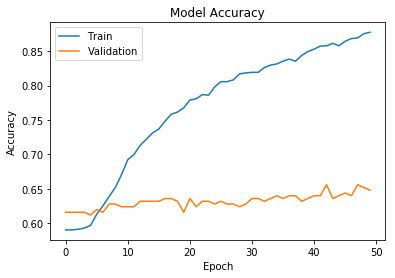

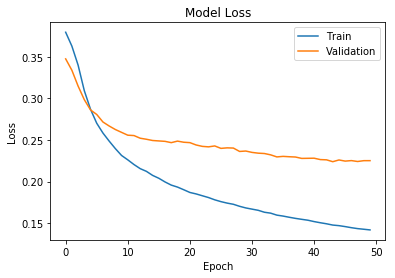

In [22]:
plt.plot(malstm_trained.history['acc'])
plt.plot(malstm_trained.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("plots/subtask_b_first_gen_model_accuracy.png")
plt.show()

# Plot loss
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig("plots/subtask_b_first_gen_model_loss.png")
plt.show()

In [23]:
X_test['left'] = pad_sequences(X_test['left'], maxlen=max_seq_length)
X_test['right'] = pad_sequences(X_test['right'], maxlen=max_seq_length)

# # Make sure everything is ok
assert X_test['left'].shape == X_test['right'].shape
# assert len(X_test['left']) == len(Y_test)


NameError: name 'Y_test' is not defined

In [25]:
Y_test = test_df['relevance']

In [26]:
score_malstm = malstm.evaluate([X_test['left'], X_test['right']], Y_test, batch_size=32, verbose=1, sample_weight=None)

634/634 [==============================] - 1s     


In [27]:
score_malstm



[0.2326524739479793, 0.6388012623937348]

In [1]:
malstm.metrics_names

NameError: name 'malstm' is not defined

malstm.metrics_names


In [28]:
Y_pred = malstm.predict([X_test['left'], X_test['right']])



In [35]:
# probs = metrics.precision_recall_curve(Y_test)
# test_acc = metrics.auc()

def display_metrics(Y, Y_pred):
    print(metrics.precision_score(Y, Y_pred),
          metrics.recall_score(Y, Y_pred),
          metrics.roc_auc_score(Y, Y_pred),
          metrics.f1_score(Y, Y_pred))
    
def give_class(x):
    return 1 if x>0.5 else 0


# prediction_metric = metrics.precision_score(Y_test, Y_pred_mapped)
# recall_metric = metrics.recall_score(Y_test, Y_pred_mapped)
# roc_metric = metrics.roc_auc_score(Y_test, Y_pred_mapped)

# f1_metric = metrics.f1_score(Y_test, Y_pred_mapped)

In [40]:
malstm.predict([X_test['left'], X_test['right']])

array([[  1.48779079e-01],
       [  1.52834162e-01],
       [  6.22249126e-01],
       [  6.11078382e-01],
       [  4.25397664e-01],
       [  2.63855189e-01],
       [  1.96980938e-01],
       [  1.56708181e-01],
       [  4.37146008e-01],
       [  3.69775891e-01],
       [  8.73972755e-03],
       [  4.49352801e-01],
       [  2.56543815e-01],
       [  1.27540946e-01],
       [  4.60197687e-01],
       [  5.48604429e-01],
       [  3.84750843e-01],
       [  4.16500688e-01],
       [  1.53029095e-02],
       [  1.60603851e-01],
       [  6.07891202e-01],
       [  3.75015795e-01],
       [  5.10629952e-01],
       [  3.14737529e-01],
       [  5.96021414e-01],
       [  4.04666990e-01],
       [  4.80910391e-01],
       [  3.83063793e-01],
       [  4.23098862e-01],
       [  1.69752702e-01],
       [  4.81844455e-01],
       [  3.64179730e-01],
       [  1.60884410e-01],
       [  2.95810163e-01],
       [  3.08922768e-01],
       [  6.20532453e-01],
       [  4.88964856e-01],
 

In [52]:
#MIARY NA TRENINGOWYM

Y_pred_train = malstm.predict([X_train['left'], X_train['right']])
Y_pred_mapped_train = list(map(give_class, Y_pred_train))

display_metrics(Y_pred_mapped_train, train_df['relevance'])

ValueError: Error when checking : expected input_1 to have shape (None, 107) but got array with shape (2535, 1)

In [53]:
X_train['left']

array([[   0,    0,    0, ...,  463,  239,  594],
       [   0,    0,    0, ...,   49,  162,   31],
       [   0,    0,    0, ..., 1214,  183,  133],
       ..., 
       [   0,    0,    0, ...,   21,    2, 5650],
       [   0,    0,    0, ...,  284, 1303,   22],
       [   0,    0,    0, ...,  500,  152, 2805]], dtype=int32)

In [42]:
Y_pred_test = malstm.predict([X_test['left'], X_test['right']])
Y_pred_mapped_test = list(map(give_class, Y_pred_test))

#MIARY NA TESTOWYM

display_metrics(Y_pred_mapped_test, test_df['relevance'])



0.312977099237 0.625954198473 0.634050657885 0.417302798982


In [110]:
print(prediction_metric, recall_metric, roc_metric, f1_metric)

0.666666666667 0.0878378378378 0.526539239775 0.155223880597


In [32]:
print(prediction_metric, recall_metric, roc_metric, f1_metric)

0.625954198473 0.312977099237 0.590628334565 0.417302798982
